In [41]:
pwd

'D:\\Number Plate Detection'

In [42]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

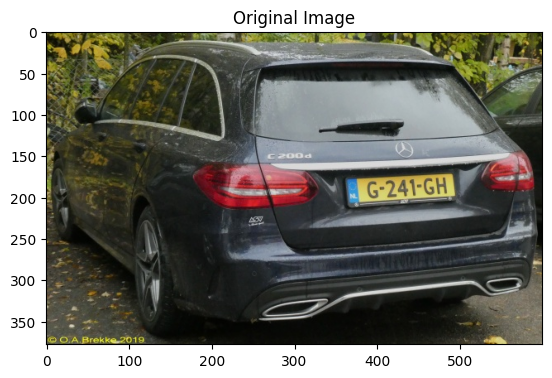

In [44]:
# Reading image file
image = cv2.imread('test_image/img25.jpeg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

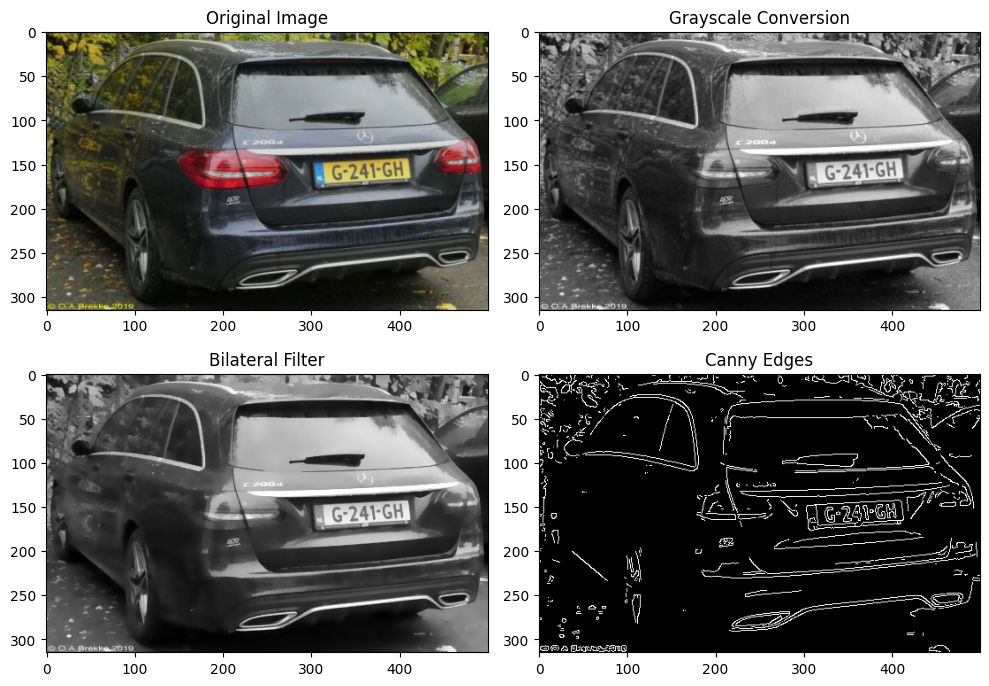

In [45]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# original image display
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

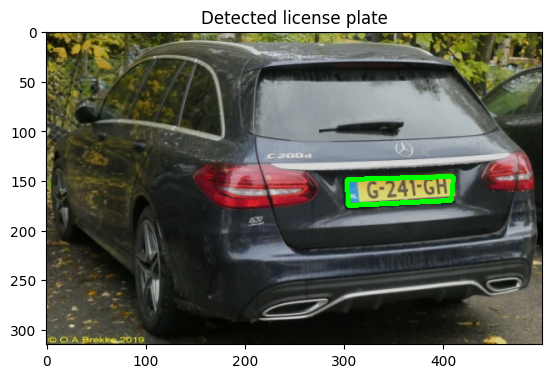

In [46]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

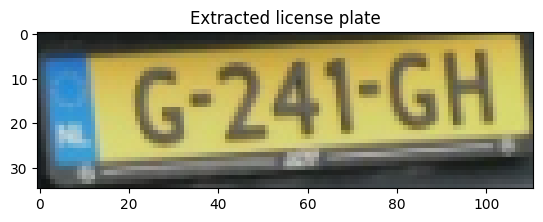

In [47]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

In [48]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [49]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

2 3


In [50]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

304 175 408 170


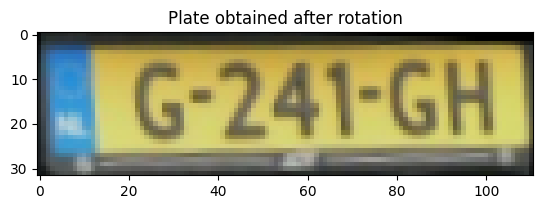

In [51]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

In [52]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [53]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

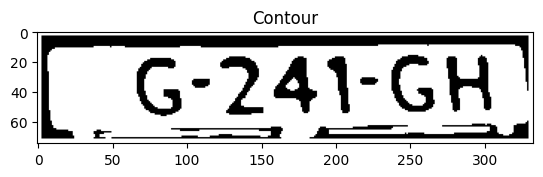

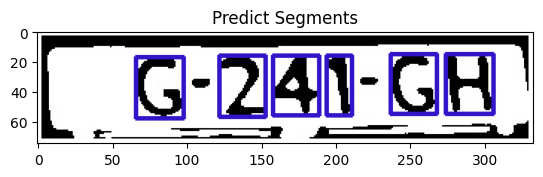

In [54]:
char=segment_characters(result)

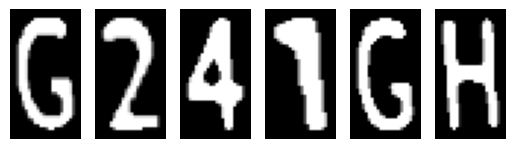

In [55]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [56]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [57]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [60]:
batch_size = 16
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 100, verbose=1, callbacks=None)

Epoch 1/100
54/54 [==============================] - 10s 185ms/step - loss: 0.2128 - accuracy: 0.9259 - val_loss: 0.0650 - val_accuracy: 0.9815
Epoch 2/100
54/54 [==============================] - 10s 186ms/step - loss: 0.0930 - accuracy: 0.9444 - val_loss: 0.0759 - val_accuracy: 0.9815
Epoch 3/100
54/54 [==============================] - 10s 179ms/step - loss: 0.0603 - accuracy: 0.9815 - val_loss: 0.0465 - val_accuracy: 0.9907
Epoch 4/100
54/54 [==============================] - 10s 181ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.0691 - val_accuracy: 0.9630
Epoch 5/100
54/54 [==============================] - 10s 178ms/step - loss: 0.0508 - accuracy: 0.9630 - val_loss: 0.0954 - val_accuracy: 0.9769
Epoch 6/100
54/54 [==============================] - 10s 190ms/step - loss: 0.0938 - accuracy: 0.9815 - val_loss: 0.0981 - val_accuracy: 0.9630
Epoch 7/100
54/54 [==============================] - 11s 196ms/step - loss: 0.1160 - accuracy: 0.9630 - val_loss: 0.1181 - val_accuracy:

54/54 [==============================] - 10s 196ms/step - loss: 0.2954 - accuracy: 0.8889 - val_loss: 0.0708 - val_accuracy: 0.9769
Epoch 58/100
54/54 [==============================] - 10s 194ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9769
Epoch 59/100
54/54 [==============================] - 10s 195ms/step - loss: 0.0751 - accuracy: 0.9630 - val_loss: 0.0467 - val_accuracy: 0.9861
Epoch 60/100
54/54 [==============================] - 10s 190ms/step - loss: 0.1105 - accuracy: 0.9630 - val_loss: 0.1462 - val_accuracy: 0.9491
Epoch 61/100
54/54 [==============================] - 10s 189ms/step - loss: 0.0297 - accuracy: 0.9815 - val_loss: 0.1200 - val_accuracy: 0.9583
Epoch 62/100
54/54 [==============================] - 10s 192ms/step - loss: 0.1159 - accuracy: 0.9630 - val_loss: 0.0786 - val_accuracy: 0.9630
Epoch 63/100
54/54 [==============================] - 10s 193ms/step - loss: 0.2761 - accuracy: 0.9074 - val_loss: 0.0445 - val_accuracy: 0.986

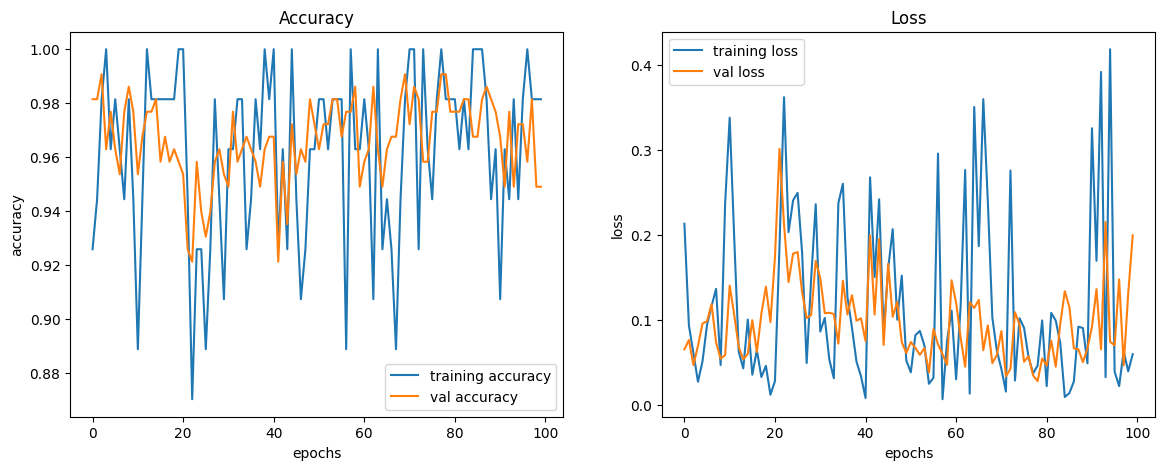

In [61]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [62]:
model.save_weights('./checkpoints/my_checkpoint')

In [63]:
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

In [64]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char:  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_ = loaded_model.predict(img)[0]  # predicting the class
        predicted_class = np.argmax(y_)  # Getting the index of the predicted class
        character = dic[predicted_class]
        output.append(character)  # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 52ms/step
G241GH


In [65]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

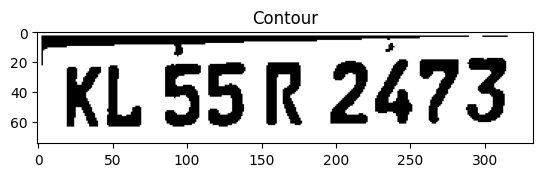

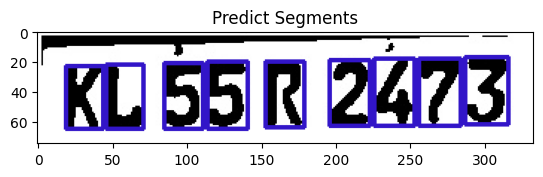

1/1 [==============================] - 0s 61ms/step
KL55R2K73


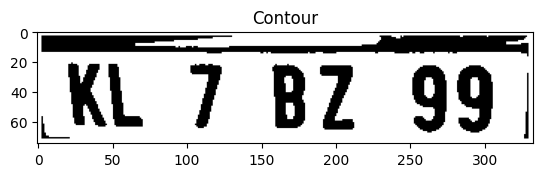

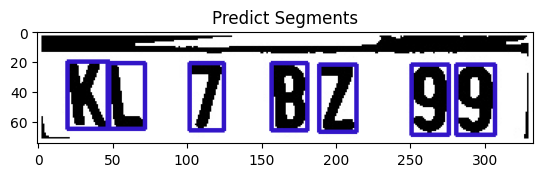

1/1 [==============================] - 0s 40ms/step
KL7BZ99


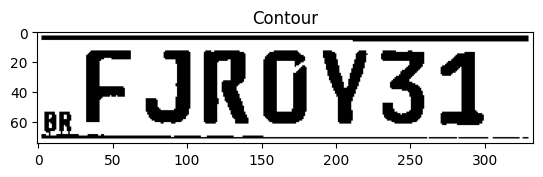

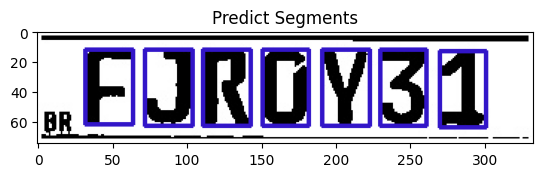

1/1 [==============================] - 0s 50ms/step
FJR0Y31


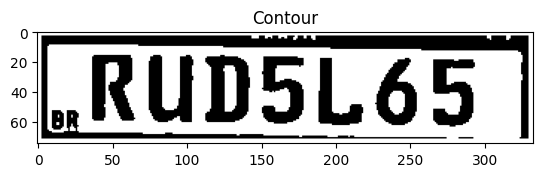

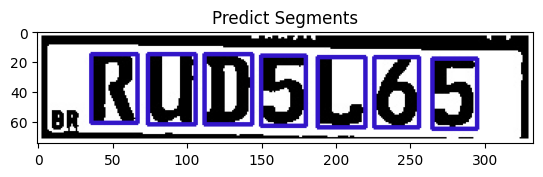

1/1 [==============================] - 0s 40ms/step
RUD5L65


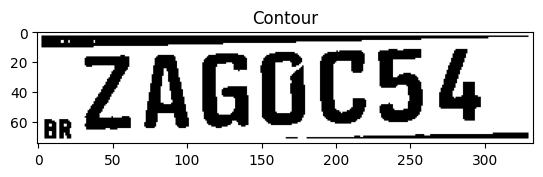

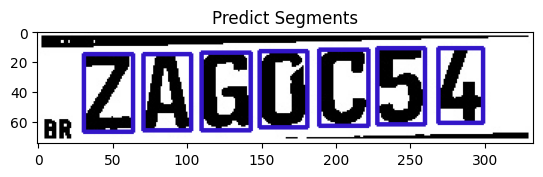

1/1 [==============================] - 0s 50ms/step
ZA60C5W


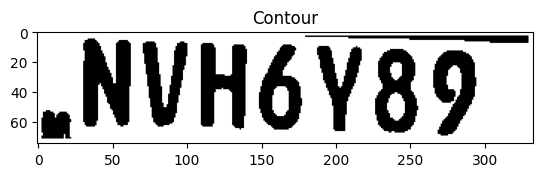

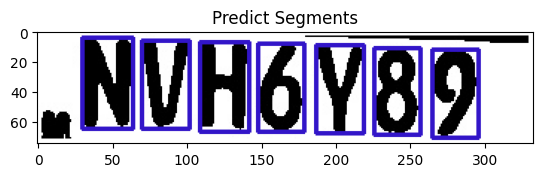

1/1 [==============================] - 0s 60ms/step
NVH6Y89


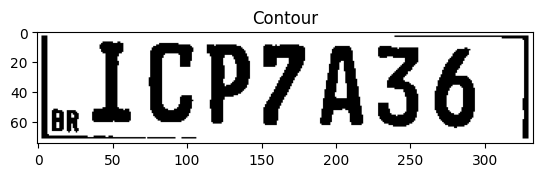

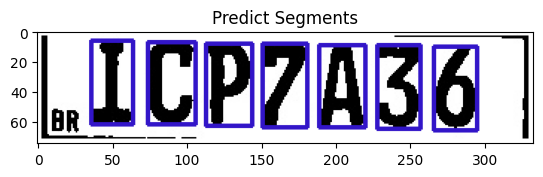

1/1 [==============================] - 0s 50ms/step
ICP7A36


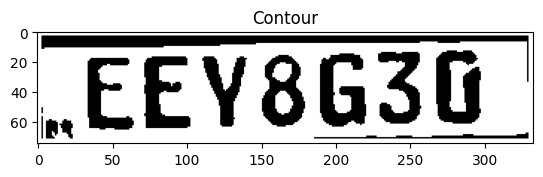

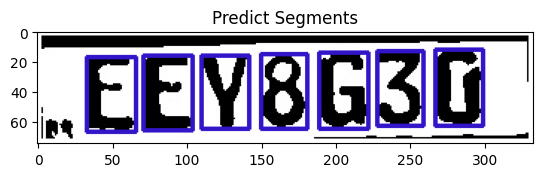

1/1 [==============================] - 0s 40ms/step
EEY863B


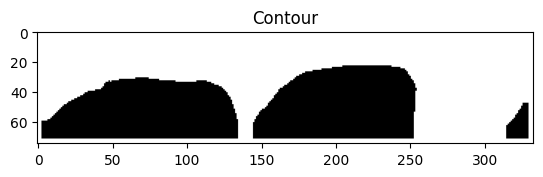

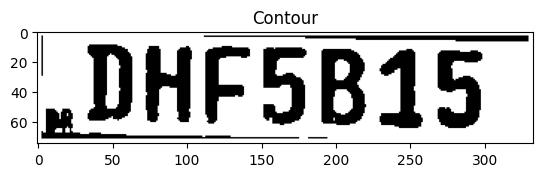

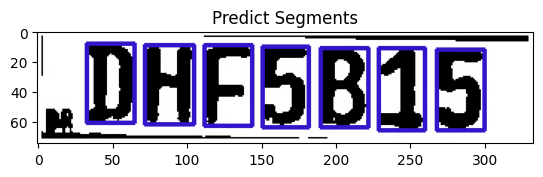

1/1 [==============================] - 0s 40ms/step
DHF5B15


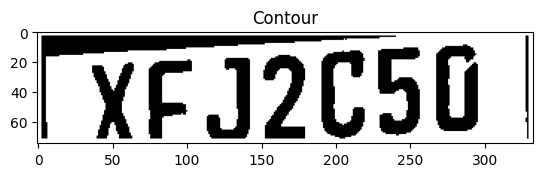

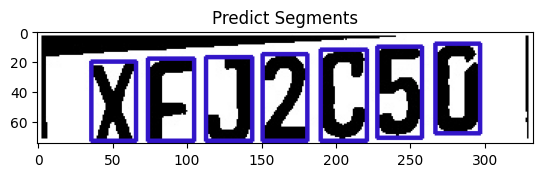

1/1 [==============================] - 0s 50ms/step
XFJ2C50


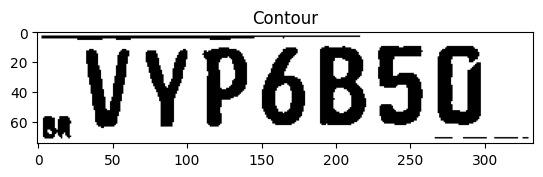

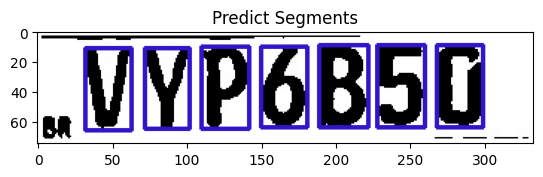

1/1 [==============================] - 0s 38ms/step
VYP6B50


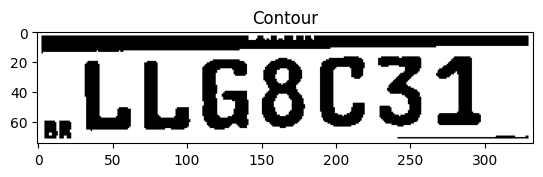

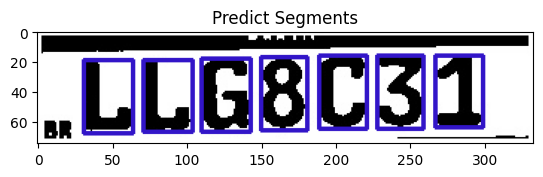

1/1 [==============================] - 0s 50ms/step
LL68C31


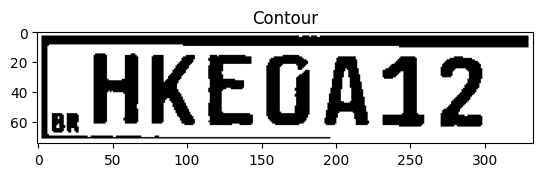

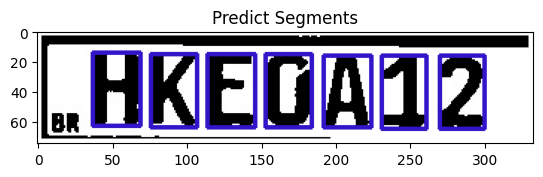

1/1 [==============================] - 0s 40ms/step
HKE0A12


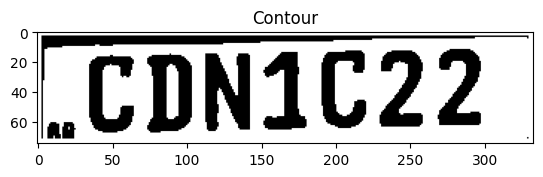

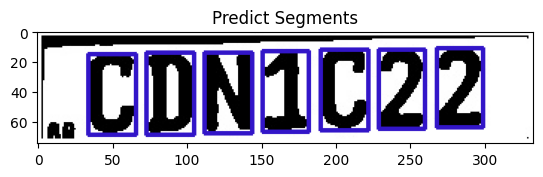

1/1 [==============================] - 0s 40ms/step
E0N1C22


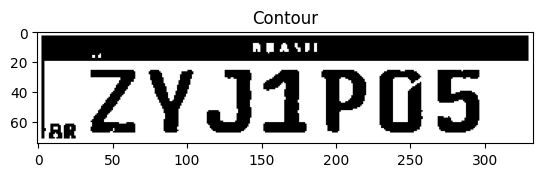

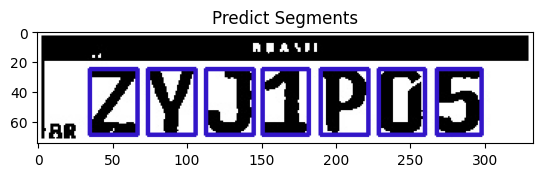

1/1 [==============================] - 0s 40ms/step
ZYJ1P05


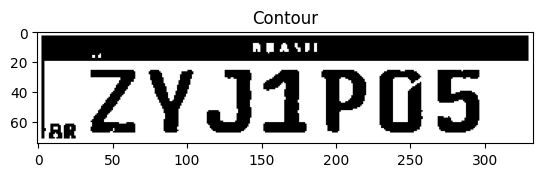

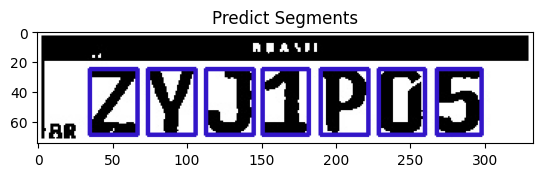

1/1 [==============================] - 0s 30ms/step
ZYJ1P05


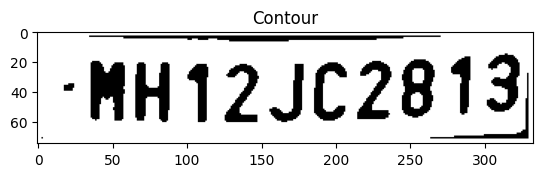

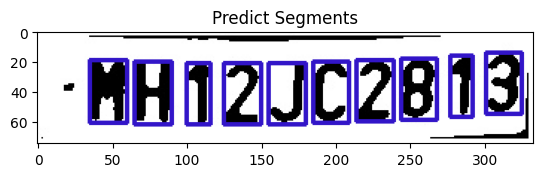

1/1 [==============================] - 0s 60ms/step
RH12JC2813


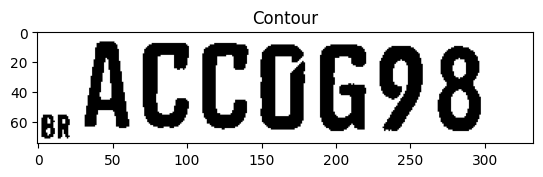

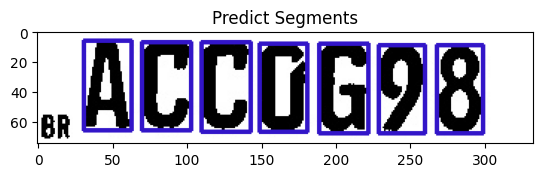

1/1 [==============================] - 0s 40ms/step
AEC0E98


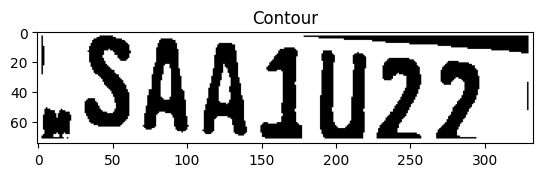

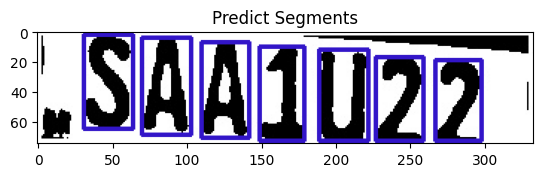

1/1 [==============================] - 0s 40ms/step
SAAJU27


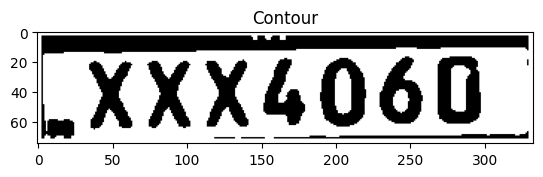

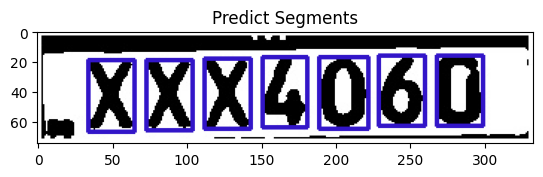

1/1 [==============================] - 0s 40ms/step
XXXW060


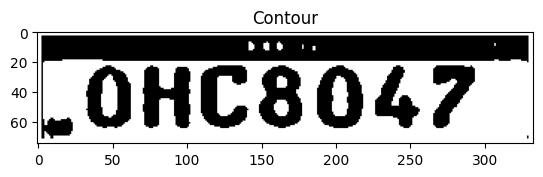

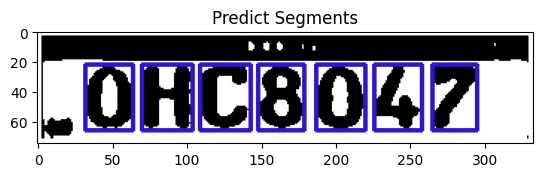

1/1 [==============================] - 0s 50ms/step
0HCB0E7


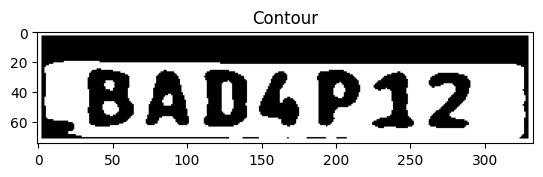

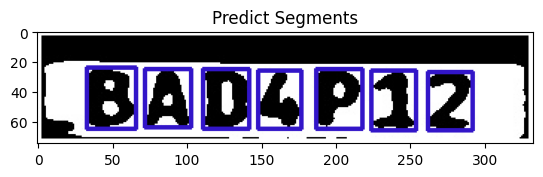

1/1 [==============================] - 0s 50ms/step
BADEP12


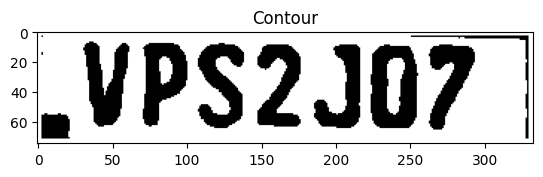

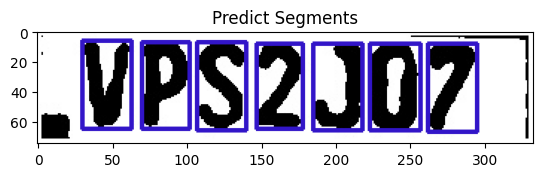

1/1 [==============================] - 0s 30ms/step
VPS2J07


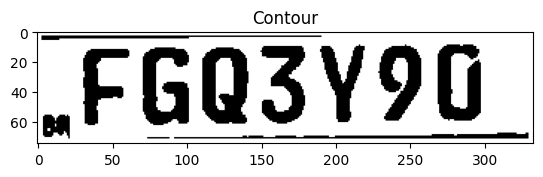

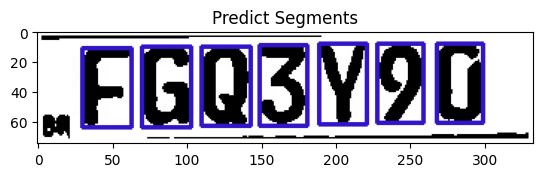

1/1 [==============================] - 0s 40ms/step
F6Q3Y90


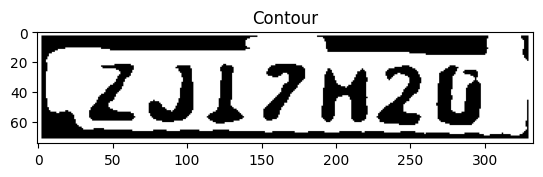

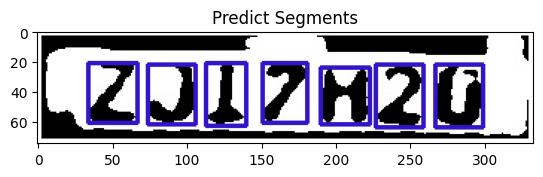

1/1 [==============================] - 0s 40ms/step
ZJ17H20


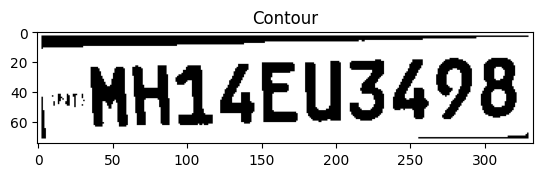

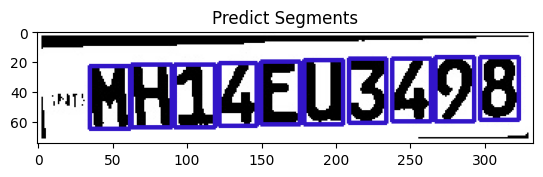

1/1 [==============================] - 0s 40ms/step
8H1WEU3W9B


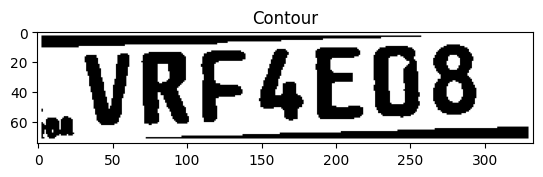

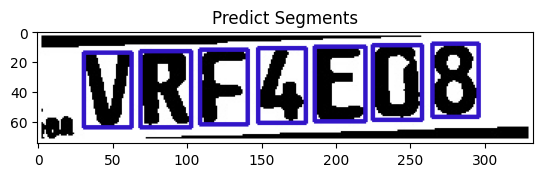

1/1 [==============================] - 0s 45ms/step
VRFWE08


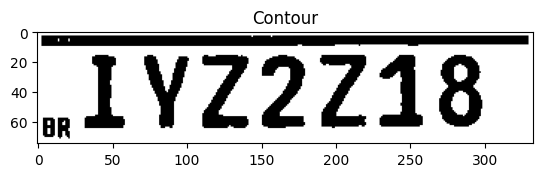

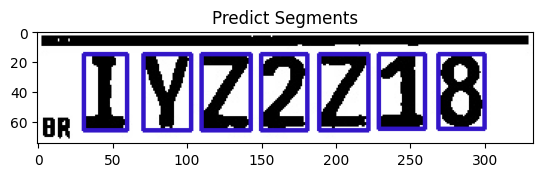

1/1 [==============================] - 0s 30ms/step
IYZ2Z18


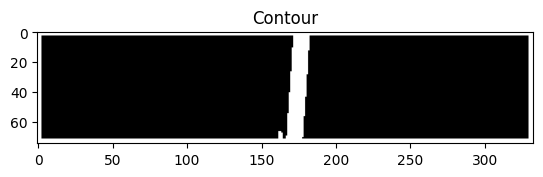

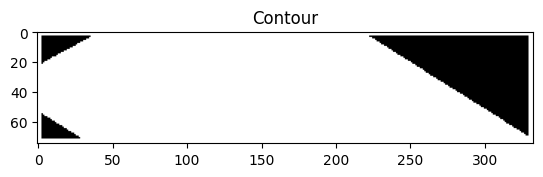

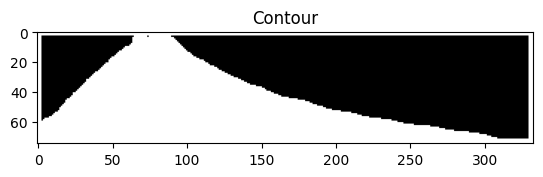

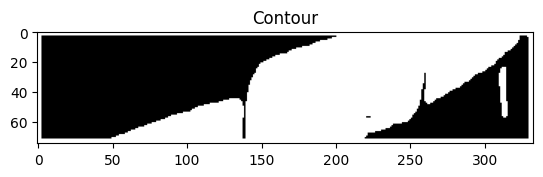

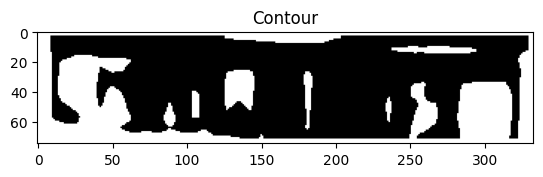

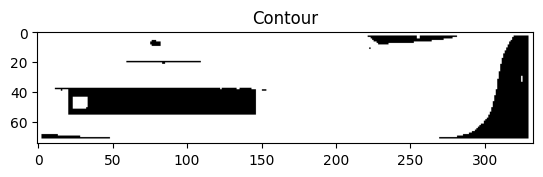

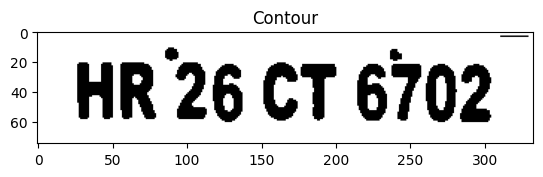

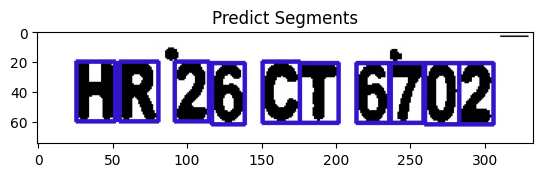

1/1 [==============================] - 0s 30ms/step
HR26CT6702


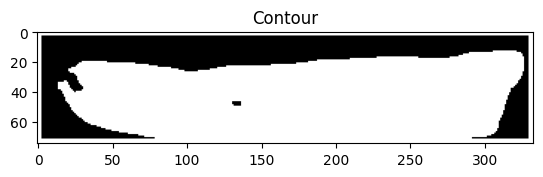

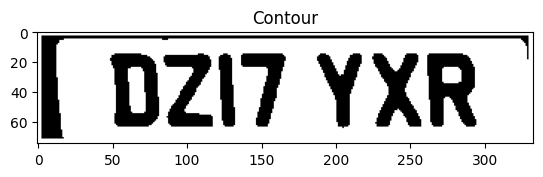

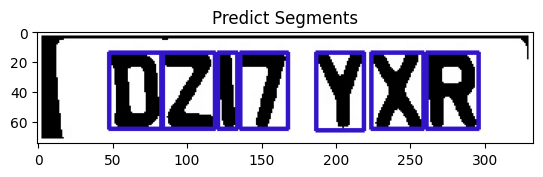

1/1 [==============================] - 0s 50ms/step
0ZI7YXR


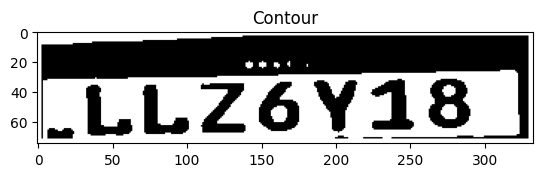

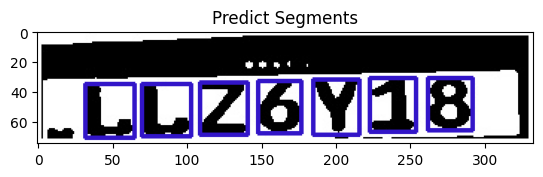

1/1 [==============================] - 0s 40ms/step
LLZ6Y18


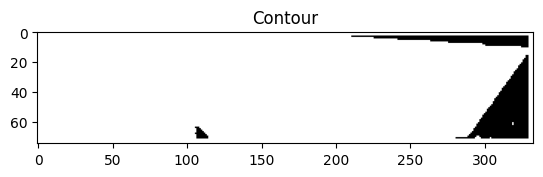

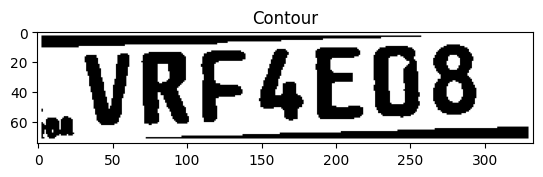

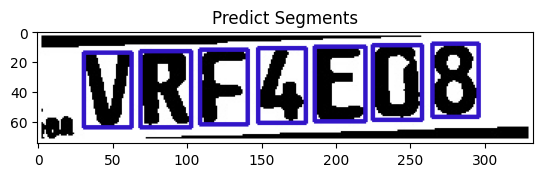

1/1 [==============================] - 0s 34ms/step
VRFWE08


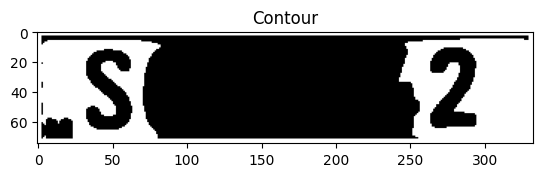

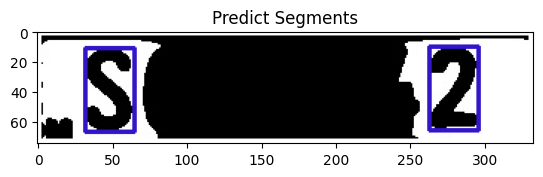

1/1 [==============================] - 0s 40ms/step
S2


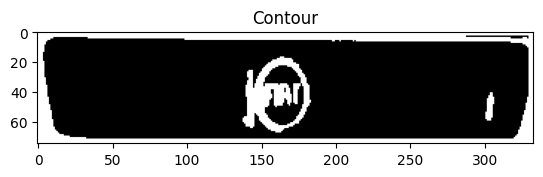

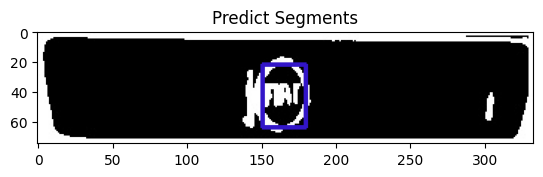

1/1 [==============================] - 0s 40ms/step
Q


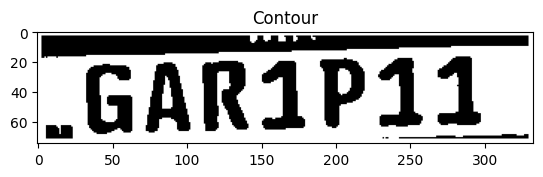

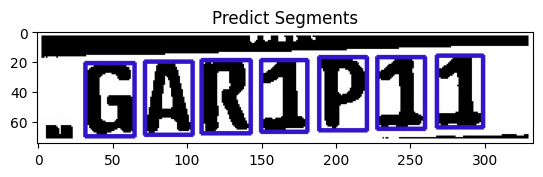

1/1 [==============================] - 0s 40ms/step
6AR1P11


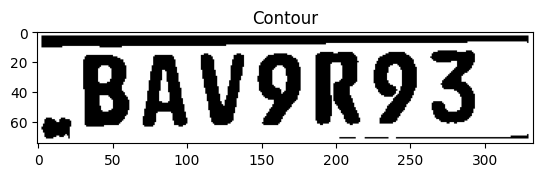

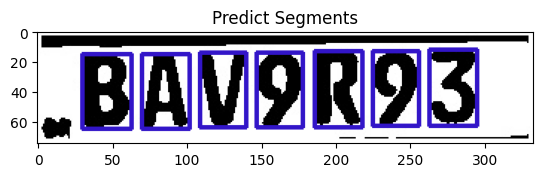

1/1 [==============================] - 0s 30ms/step
BAV9R93


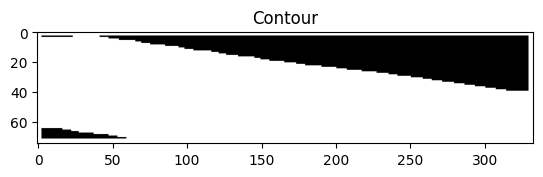

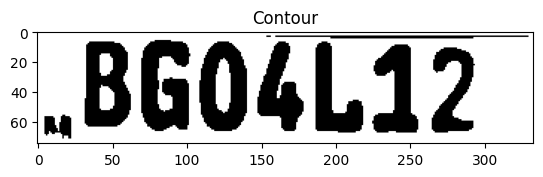

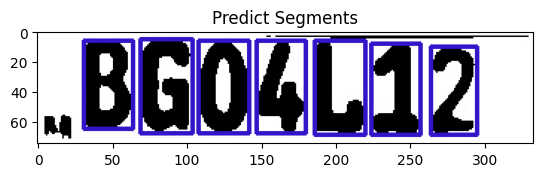

1/1 [==============================] - 0s 30ms/step
BE0EL12


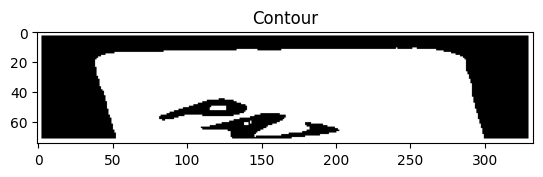

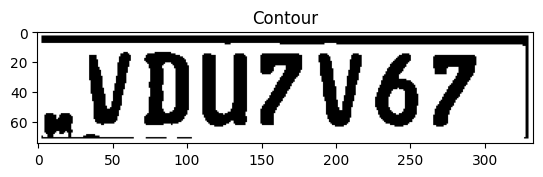

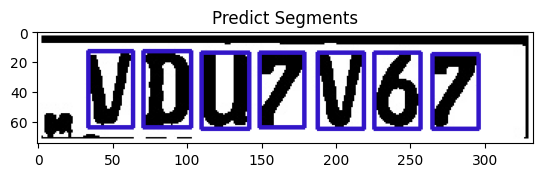

1/1 [==============================] - 0s 50ms/step
VDU7V67


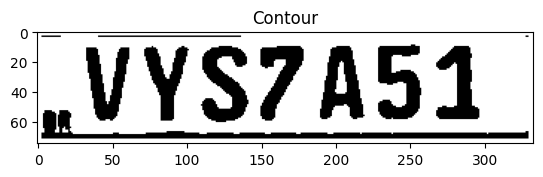

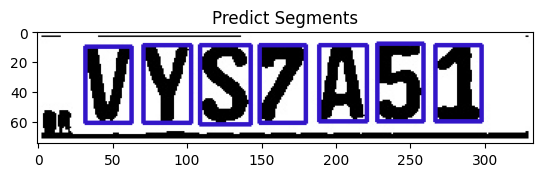

1/1 [==============================] - 0s 40ms/step
VYS7A51


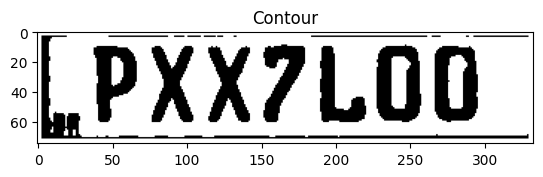

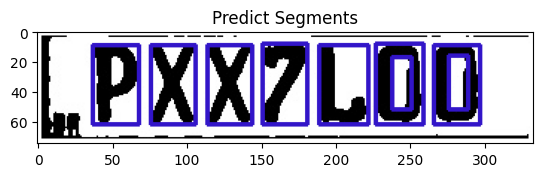

1/1 [==============================] - 0s 30ms/step
PXX7L0J0J


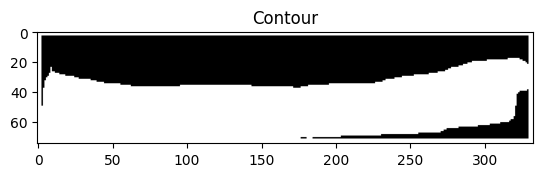

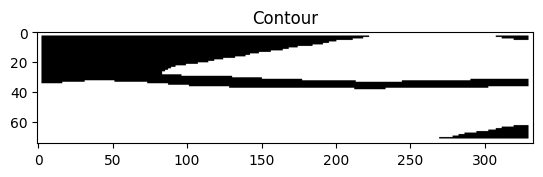

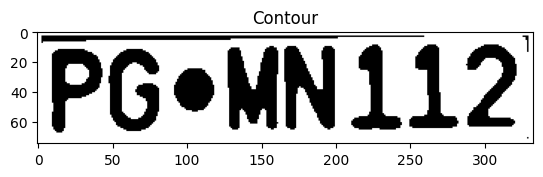

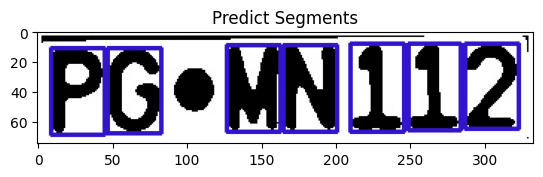

1/1 [==============================] - 0s 30ms/step
PGMN112


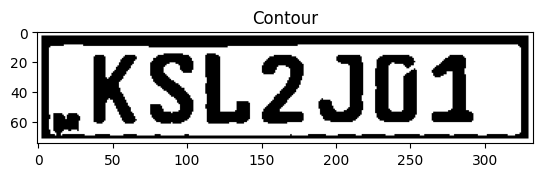

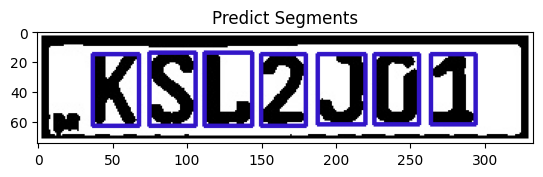

1/1 [==============================] - 0s 30ms/step
KSL2J01


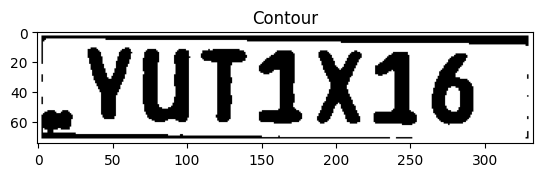

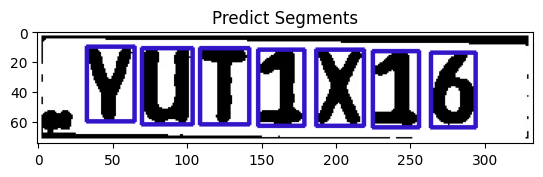

1/1 [==============================] - 0s 40ms/step
YUT1X16


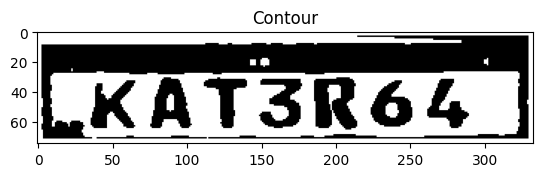

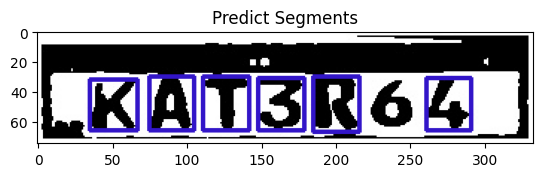

1/1 [==============================] - 0s 40ms/step
KAT3RW


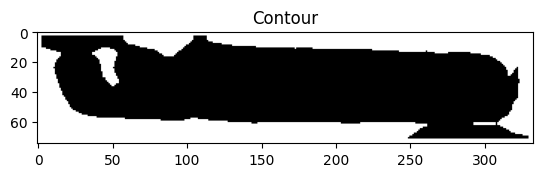

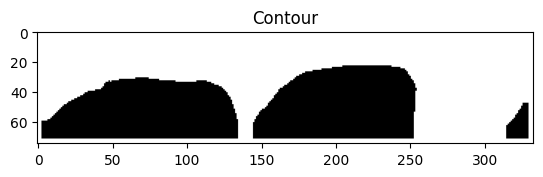

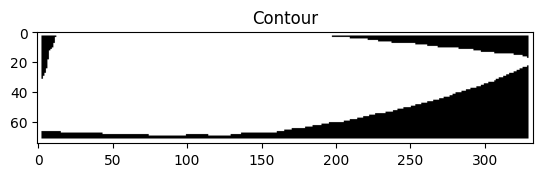

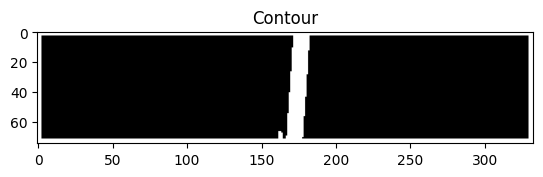

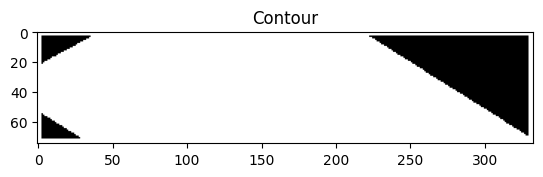

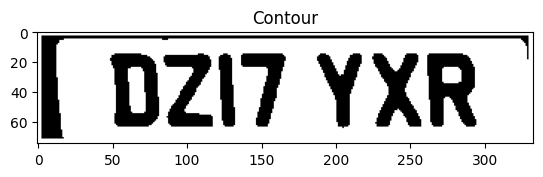

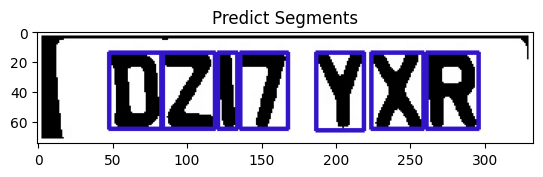

1/1 [==============================] - 0s 30ms/step
0ZI7YXR


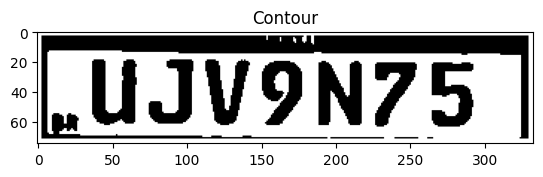

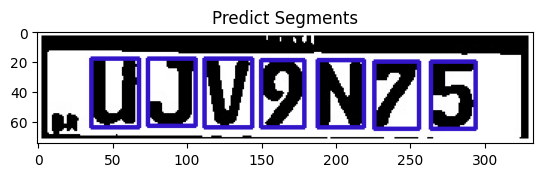

1/1 [==============================] - 0s 30ms/step
UJV9N75


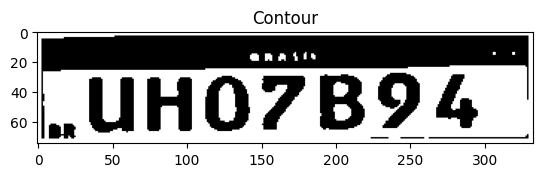

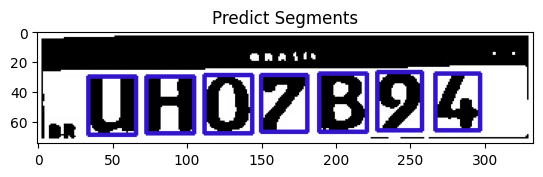

1/1 [==============================] - 0s 40ms/step
UH07B9W


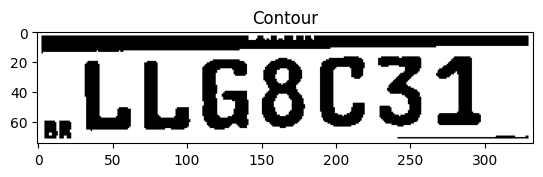

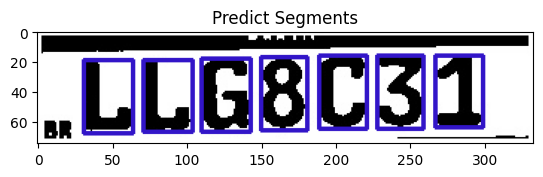

1/1 [==============================] - 0s 40ms/step
LL68C31


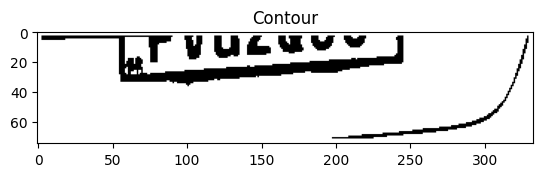

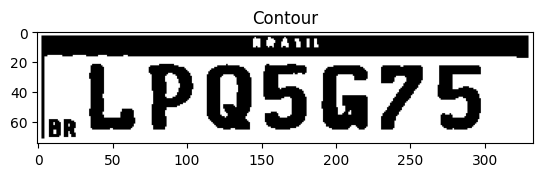

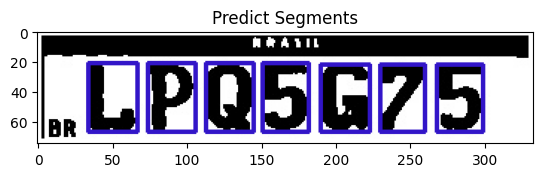

1/1 [==============================] - 0s 50ms/step
LPQ5E75


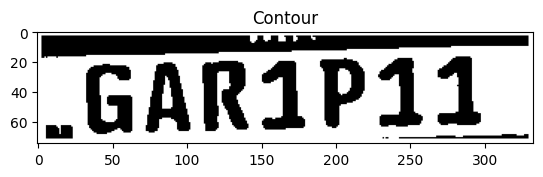

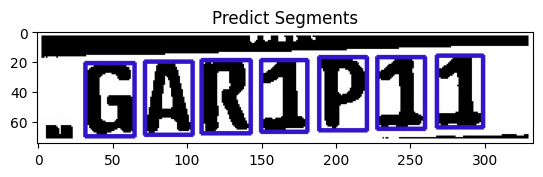

1/1 [==============================] - 0s 40ms/step
6AR1P11


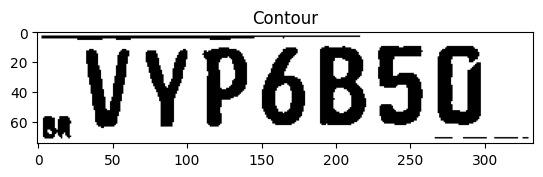

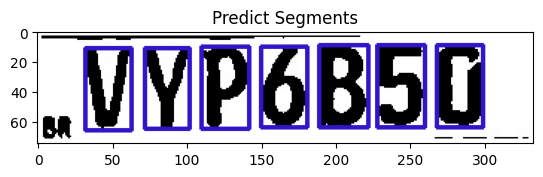

1/1 [==============================] - 0s 40ms/step
VYP6B50


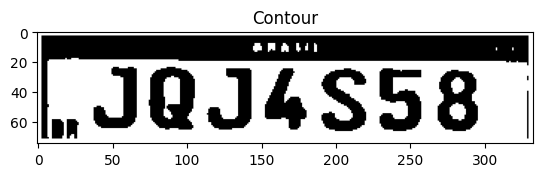

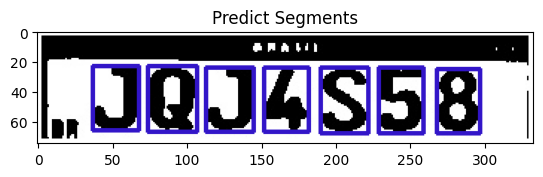

1/1 [==============================] - 0s 27ms/step
JQJES58


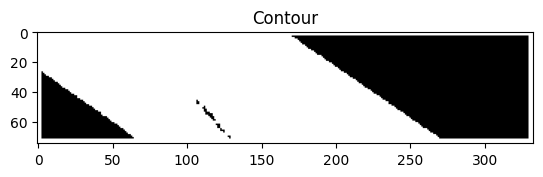

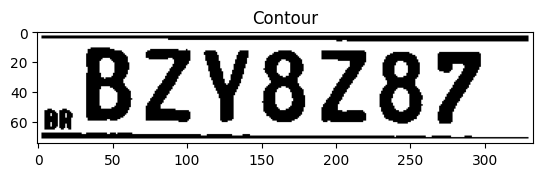

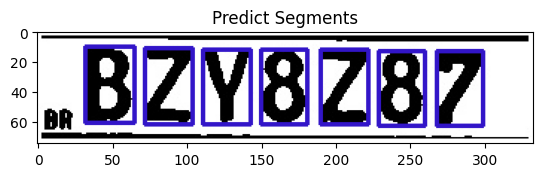

1/1 [==============================] - 0s 30ms/step
BZY8Z87


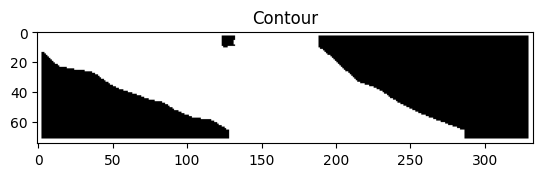

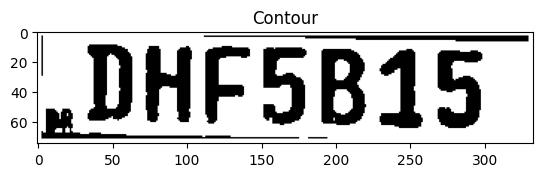

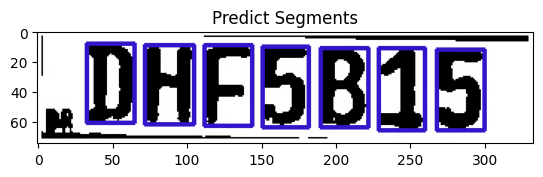

1/1 [==============================] - 0s 30ms/step
DHF5B15


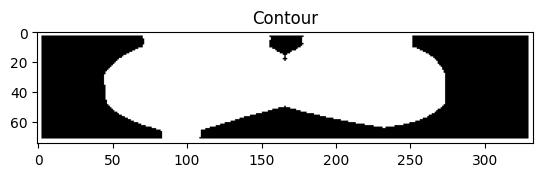

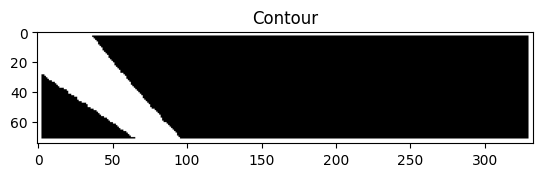

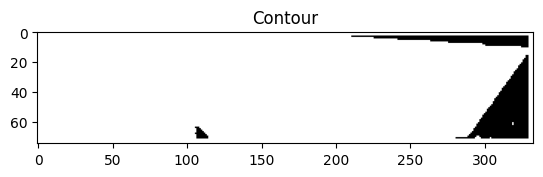

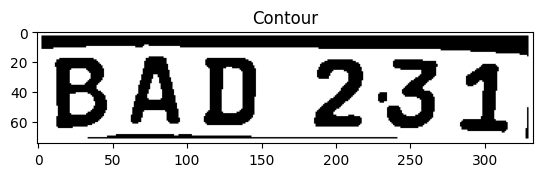

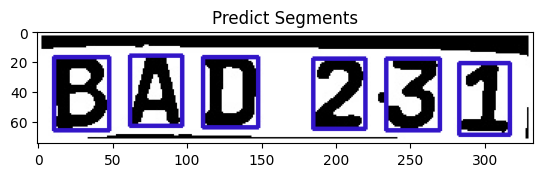

1/1 [==============================] - 0s 40ms/step
BAD231


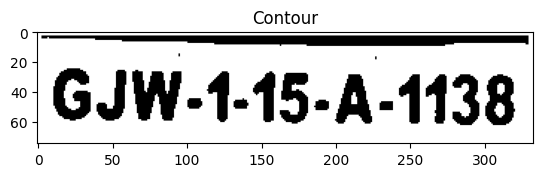

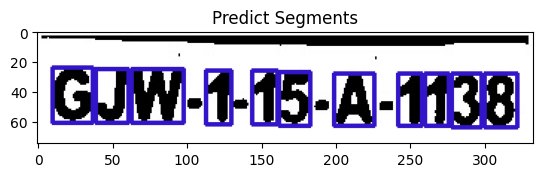

1/1 [==============================] - 0s 40ms/step
GJW115A113B


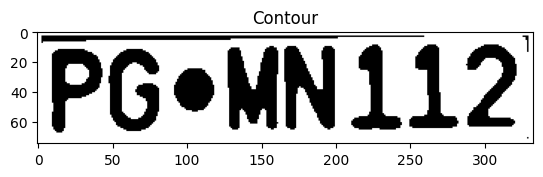

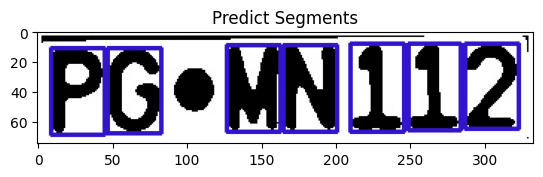

1/1 [==============================] - 0s 40ms/step
PGMN112


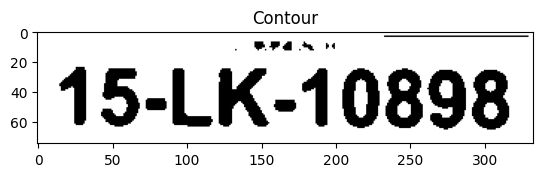

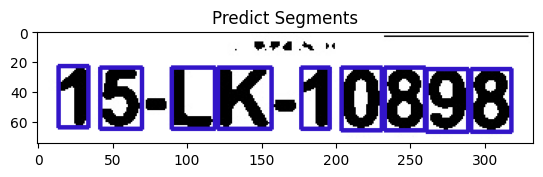

1/1 [==============================] - 0s 30ms/step
15LK1089B


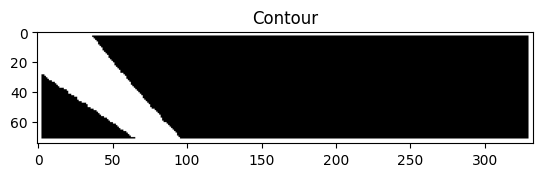

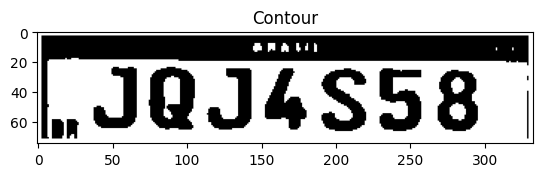

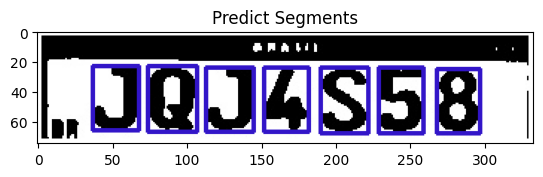

1/1 [==============================] - 0s 30ms/step
JQJES58


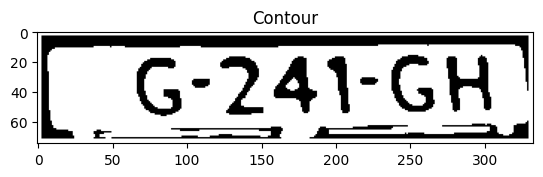

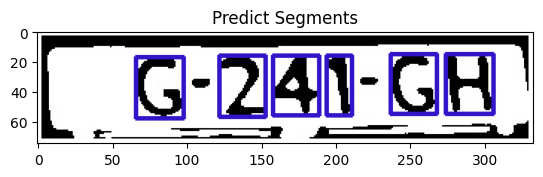

1/1 [==============================] - 0s 40ms/step
G241GH


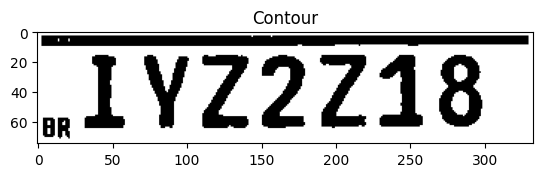

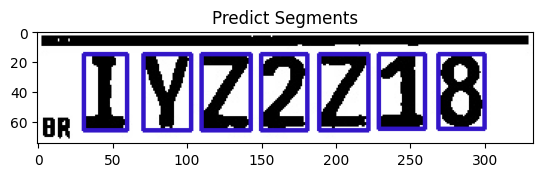

1/1 [==============================] - 0s 48ms/step
IYZ2Z18


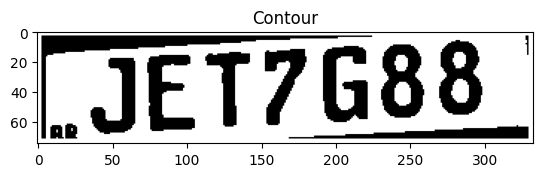

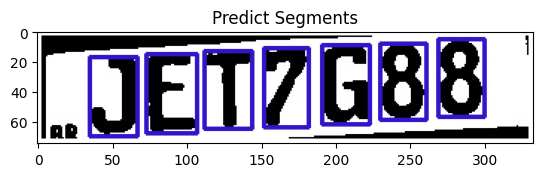

1/1 [==============================] - 0s 40ms/step
JET7688


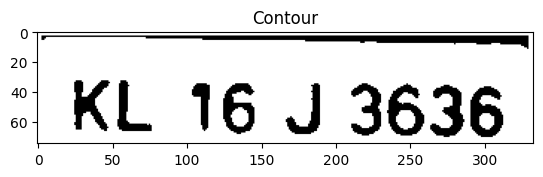

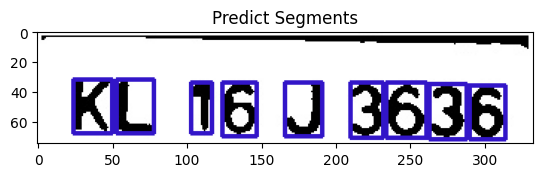

1/1 [==============================] - 0s 40ms/step
KL16J3636


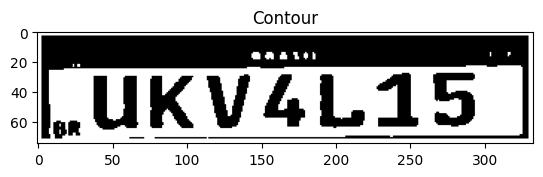

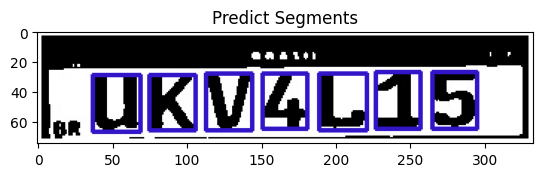

1/1 [==============================] - 0s 50ms/step
UKVWL15


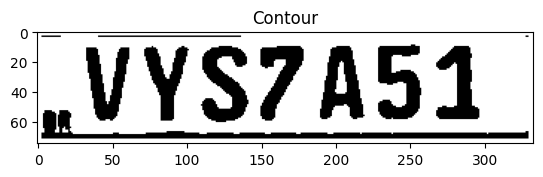

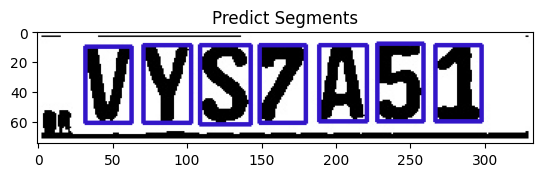

1/1 [==============================] - 0s 40ms/step
VYS7A51


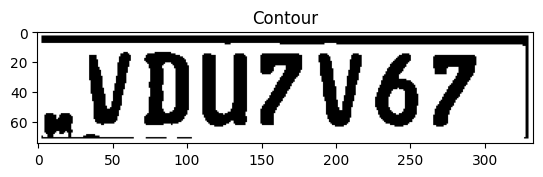

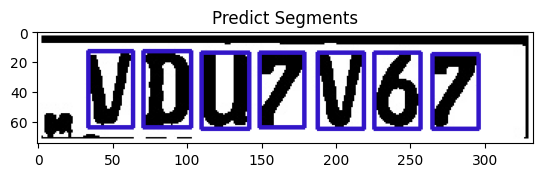

1/1 [==============================] - 0s 40ms/step
VDU7V67


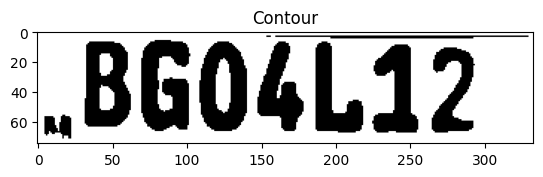

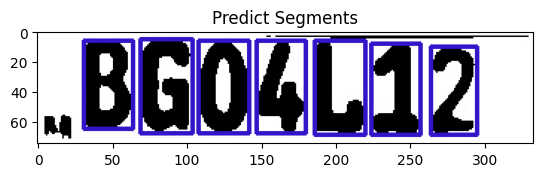

1/1 [==============================] - 0s 50ms/step
BE0EL12


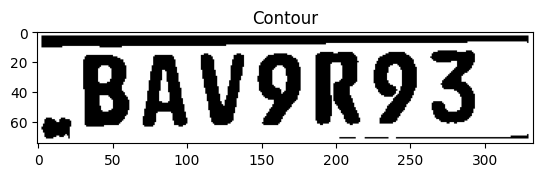

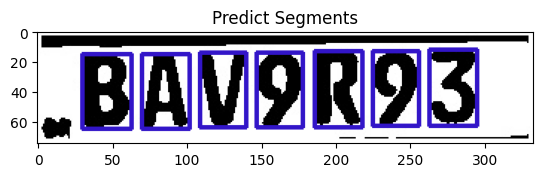

1/1 [==============================] - 0s 50ms/step
BAV9R93


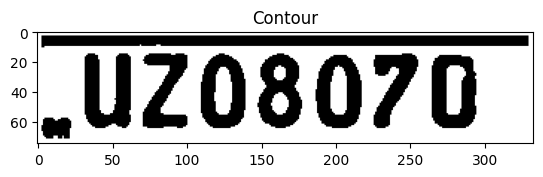

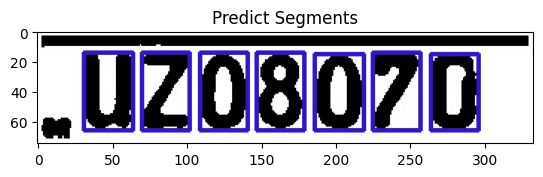

1/1 [==============================] - 0s 30ms/step
UZ0B070


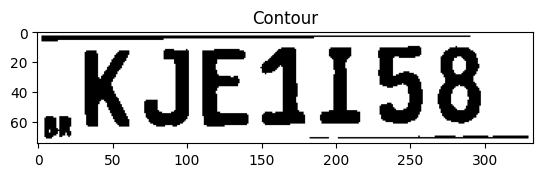

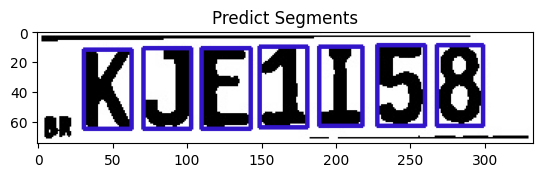

1/1 [==============================] - 0s 40ms/step
KJE1I58


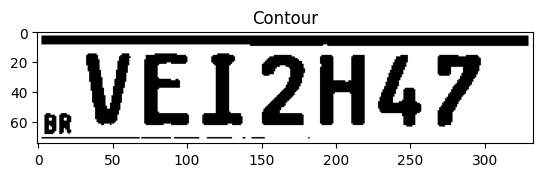

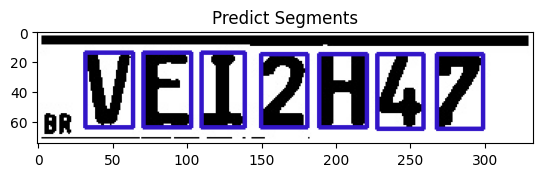

1/1 [==============================] - 0s 40ms/step
VEI2HW7


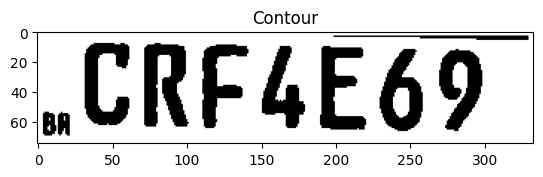

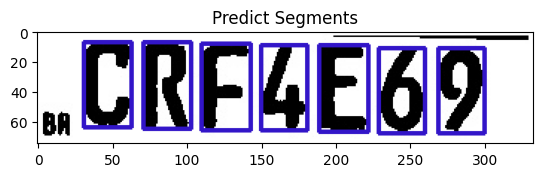

1/1 [==============================] - 0s 40ms/step
CRFWE69


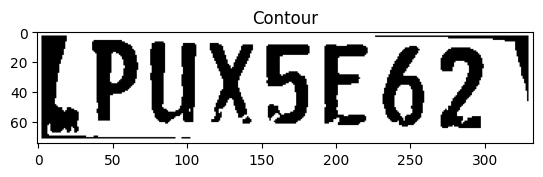

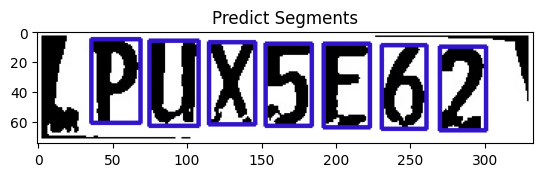

1/1 [==============================] - 0s 44ms/step
PUX5E62


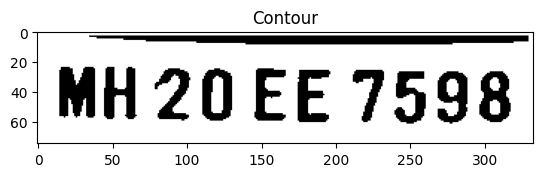

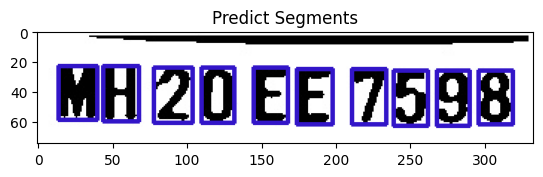

1/1 [==============================] - 0s 40ms/step
MH20EE7598


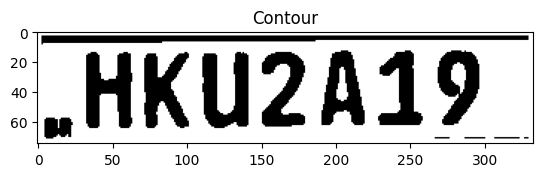

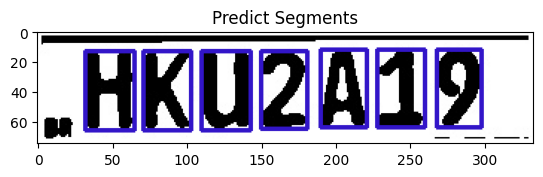

1/1 [==============================] - 0s 50ms/step
HKU2A19


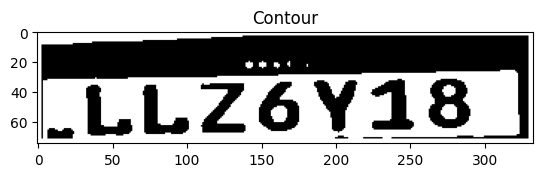

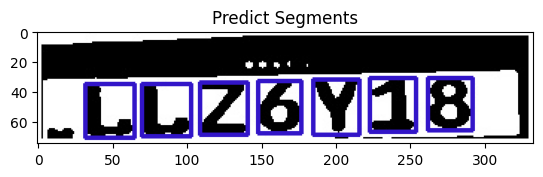

1/1 [==============================] - 0s 40ms/step
LLZ6Y18


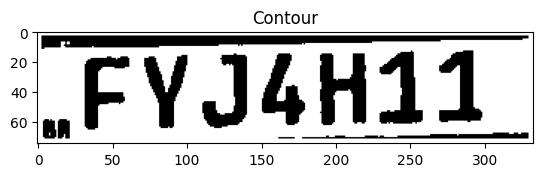

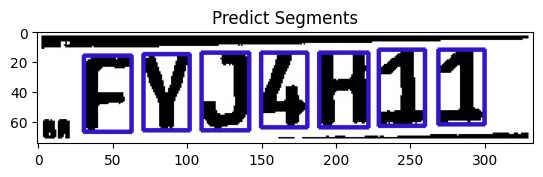

1/1 [==============================] - 0s 40ms/step
FYJWH11


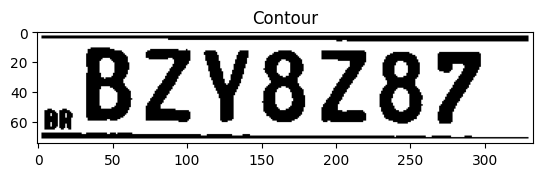

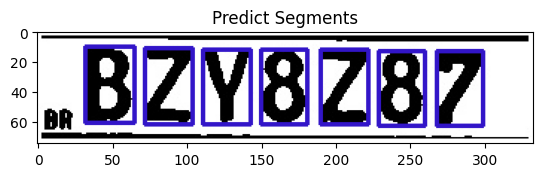

1/1 [==============================] - 0s 30ms/step
BZY8Z87


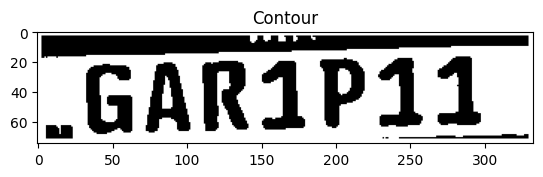

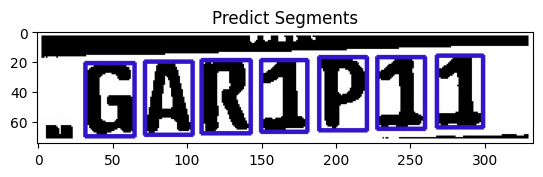

1/1 [==============================] - 0s 40ms/step
6AR1P11


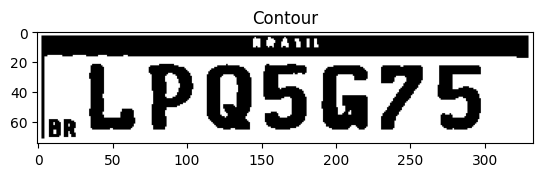

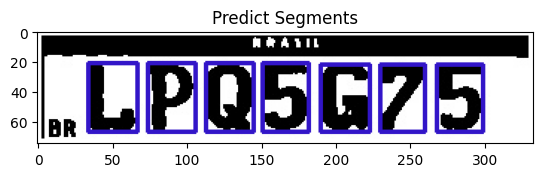

1/1 [==============================] - 0s 29ms/step
LPQ5E75


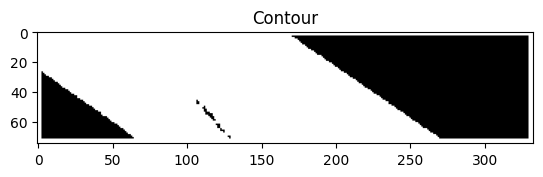

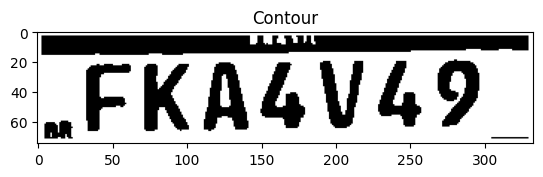

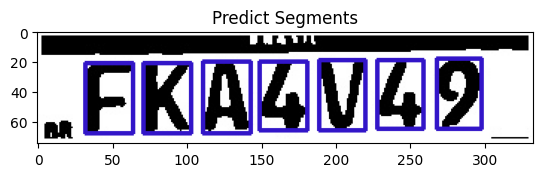

1/1 [==============================] - 0s 40ms/step
FKAWVW9


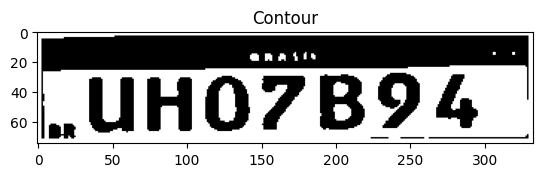

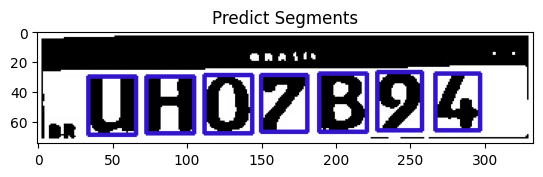

1/1 [==============================] - 0s 40ms/step
UH07B9W


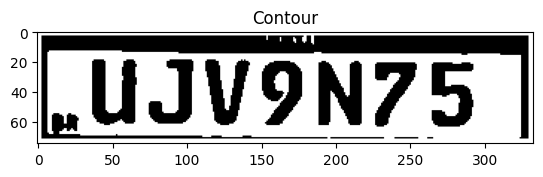

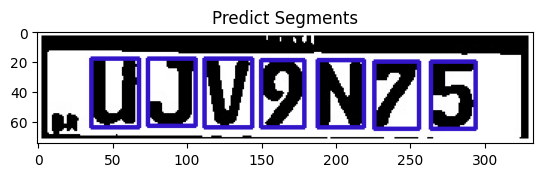

1/1 [==============================] - 0s 38ms/step
UJV9N75


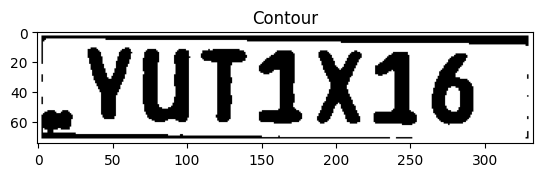

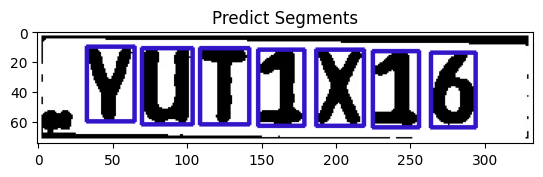

1/1 [==============================] - 0s 50ms/step
YUT1X16


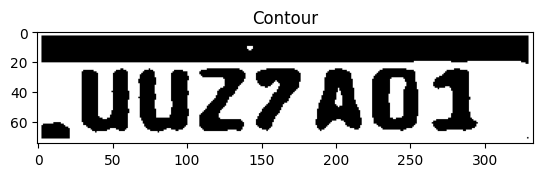

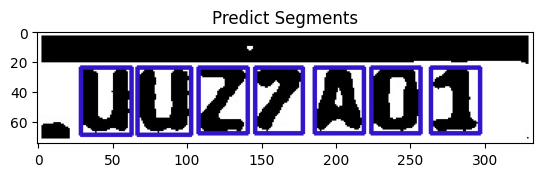

1/1 [==============================] - 0s 29ms/step
UUZ7A01


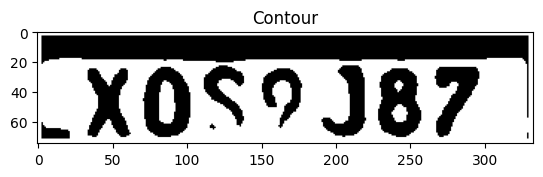

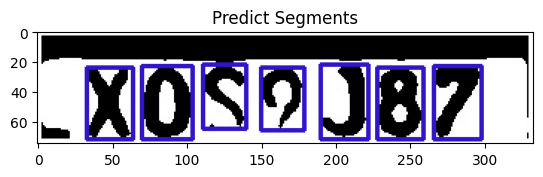

1/1 [==============================] - 0s 30ms/step
X0SQJB7


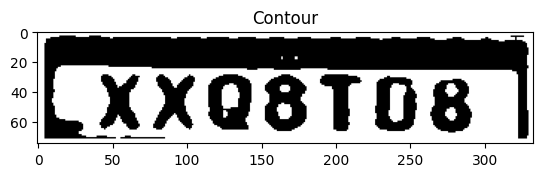

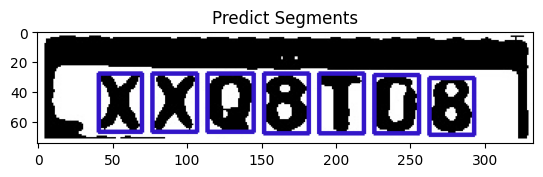

1/1 [==============================] - 0s 50ms/step
XXQBT0B


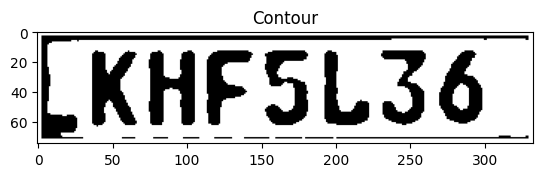

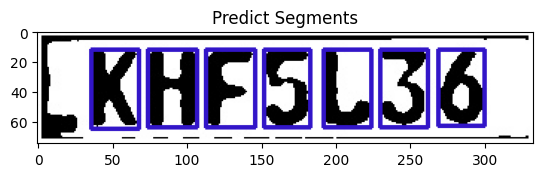

1/1 [==============================] - 0s 50ms/step
KHF5LG6


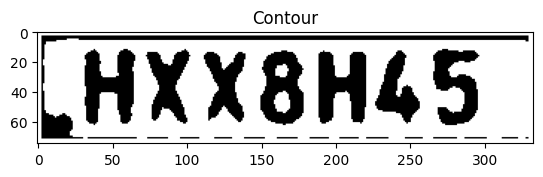

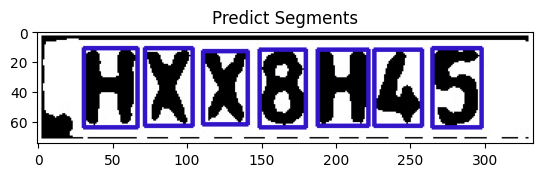

1/1 [==============================] - 0s 54ms/step
HXXBHE5


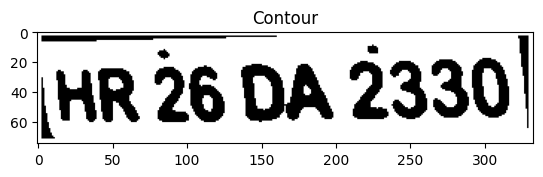

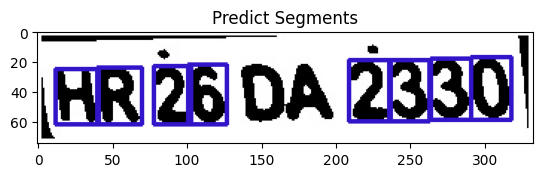

1/1 [==============================] - 0s 50ms/step
BR262530


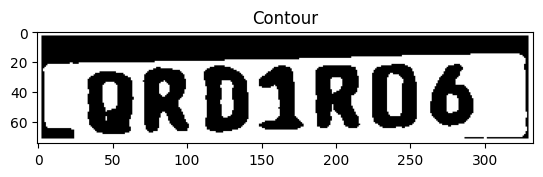

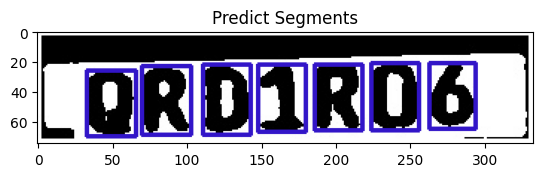

1/1 [==============================] - 0s 50ms/step
QR01R05


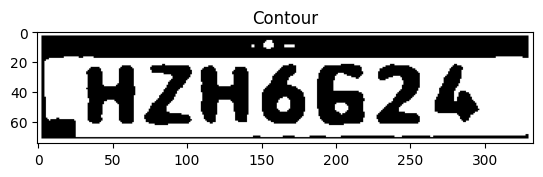

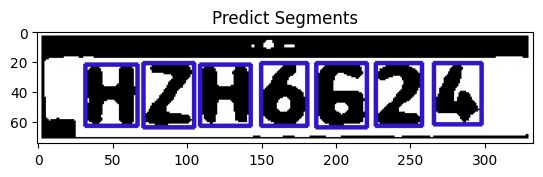

1/1 [==============================] - 0s 40ms/step
HZH6E2E


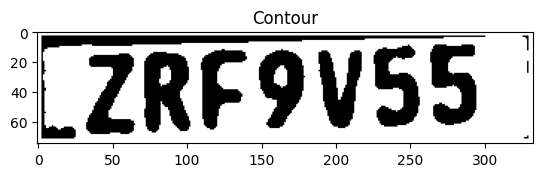

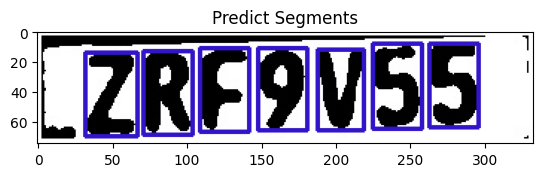

1/1 [==============================] - 0s 40ms/step
ZRF9V55


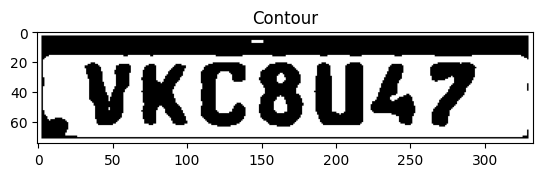

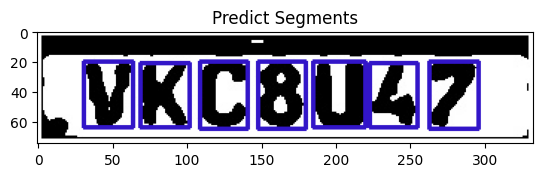

1/1 [==============================] - 0s 30ms/step
VKCBUE7


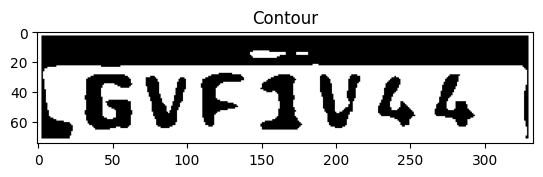

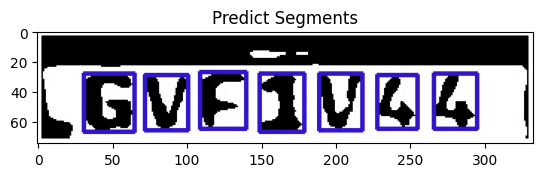

1/1 [==============================] - 0s 30ms/step
EVF1VEW


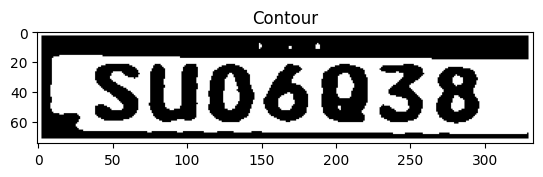

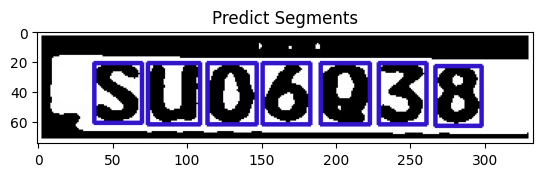

1/1 [==============================] - 0s 69ms/step
SU06Q3B


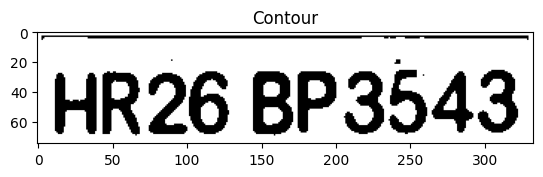

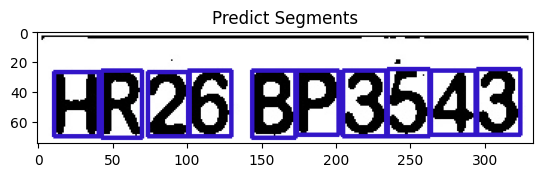

1/1 [==============================] - 0s 51ms/step
HR26BP3543


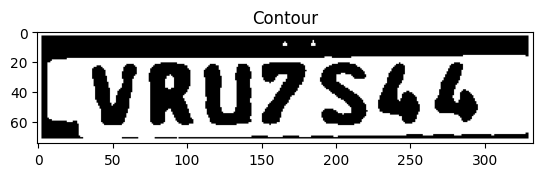

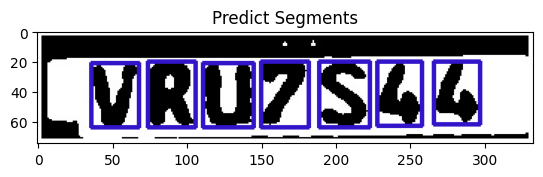

1/1 [==============================] - 0s 42ms/step
VRU7SEE


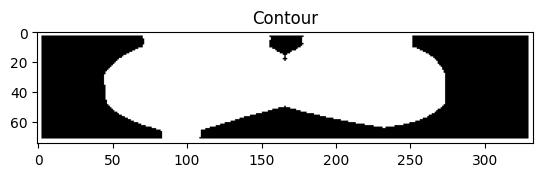

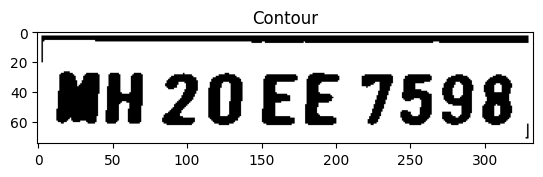

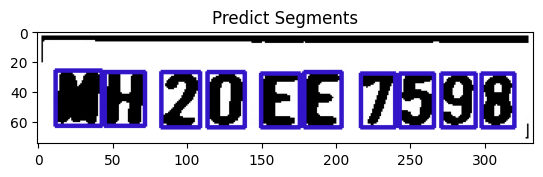

1/1 [==============================] - 0s 34ms/step
EH20EE7598


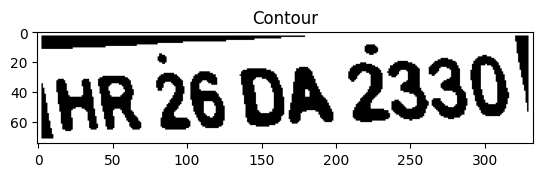

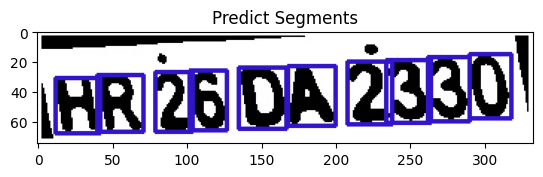

1/1 [==============================] - 0s 38ms/step
BR260A2550


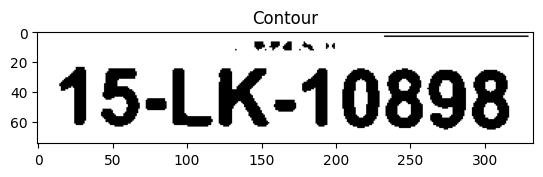

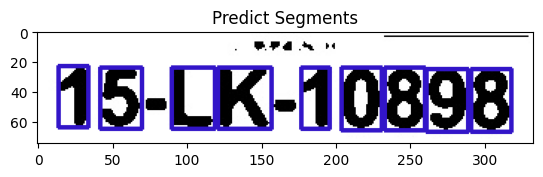

1/1 [==============================] - 0s 44ms/step
15LK1089B


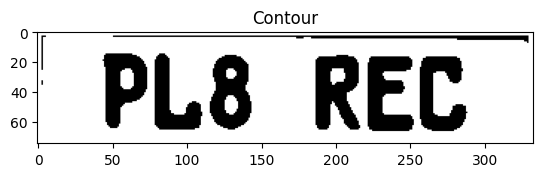

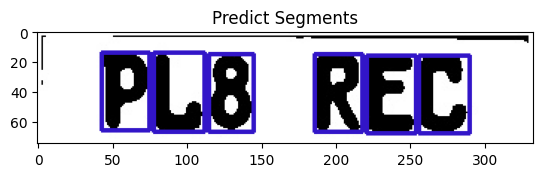

1/1 [==============================] - 0s 47ms/step
PLBREE


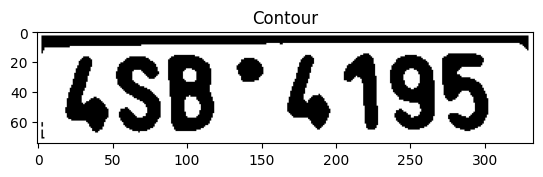

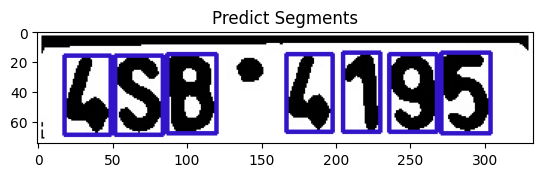

1/1 [==============================] - 0s 40ms/step
ESBE195


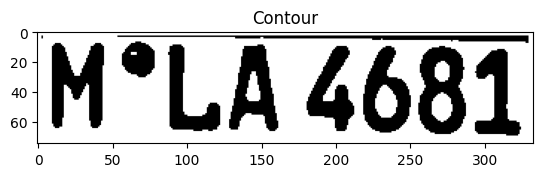

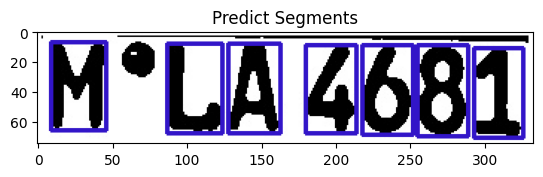

1/1 [==============================] - 0s 56ms/step
HLAK5B1


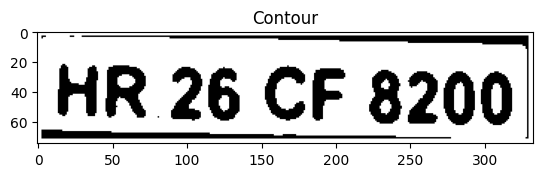

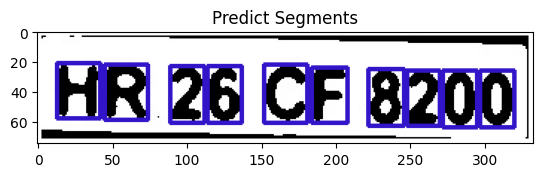

1/1 [==============================] - 0s 48ms/step
HR26CFB200


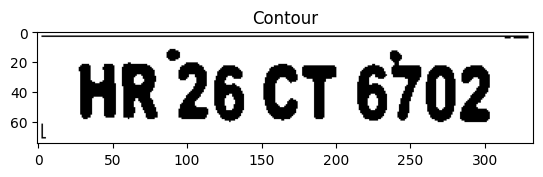

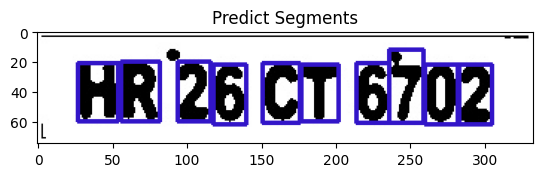

1/1 [==============================] - 0s 47ms/step
HR26CT6702


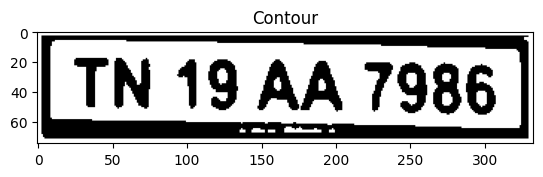

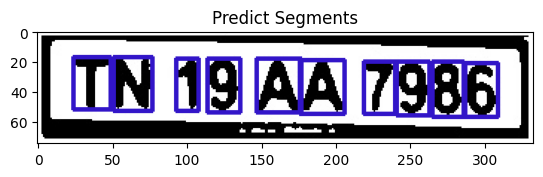

1/1 [==============================] - 0s 43ms/step
TN19AA79B6


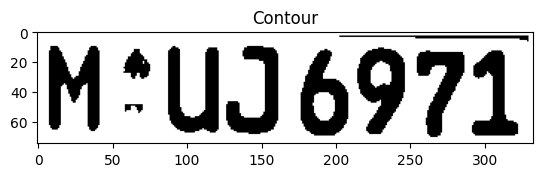

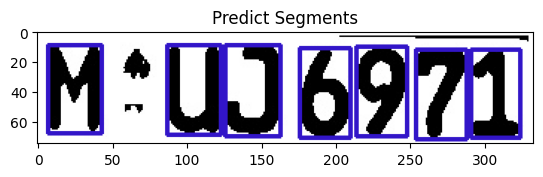

1/1 [==============================] - 0s 40ms/step
HUJ5971


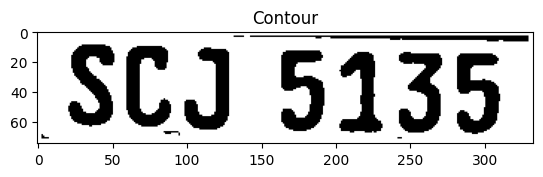

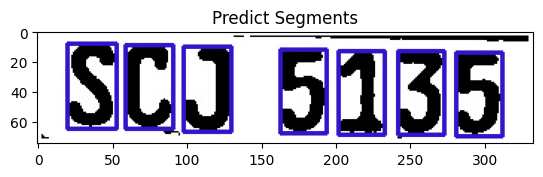

1/1 [==============================] - 0s 40ms/step
SEJ5135


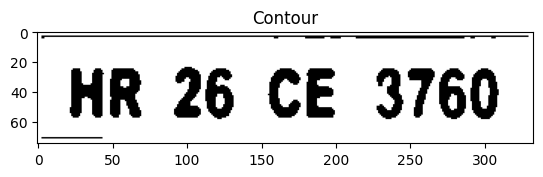

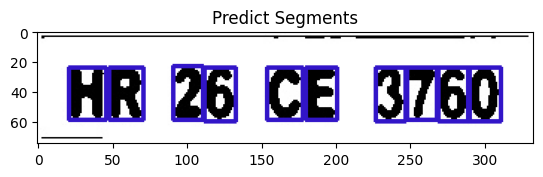

1/1 [==============================] - 0s 30ms/step
HR26CE3760


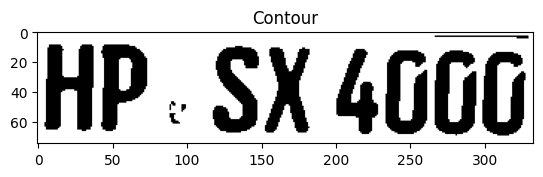

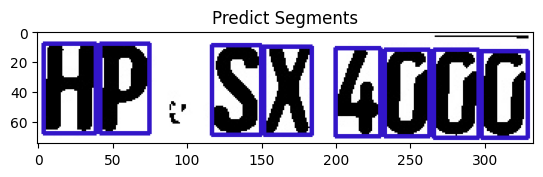

1/1 [==============================] - 0s 45ms/step
HPSXW000


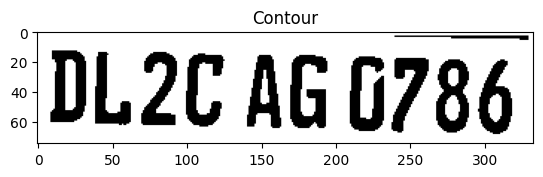

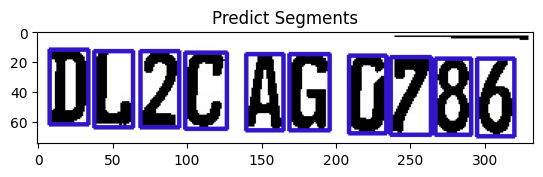

1/1 [==============================] - 0s 40ms/step
DL2CAE0786


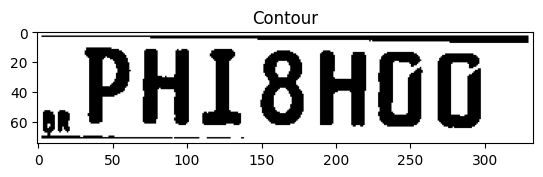

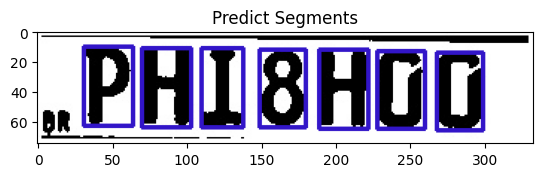

1/1 [==============================] - 0s 40ms/step
PHI8H00


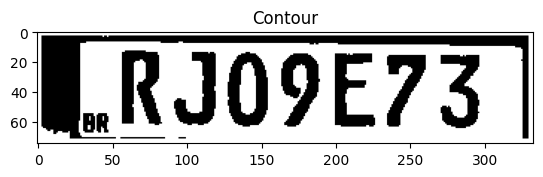

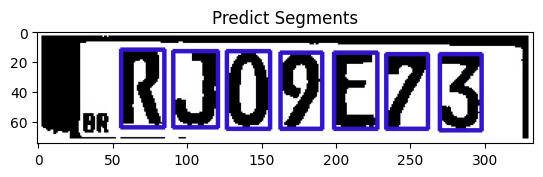

1/1 [==============================] - 0s 40ms/step
RJ09E73


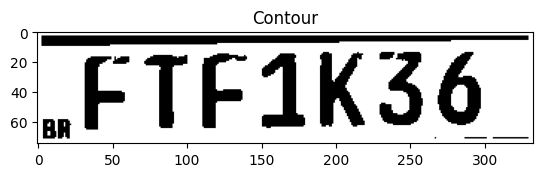

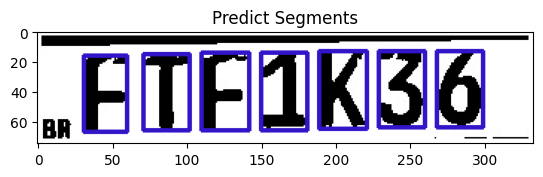

1/1 [==============================] - 0s 40ms/step
FTF1K36


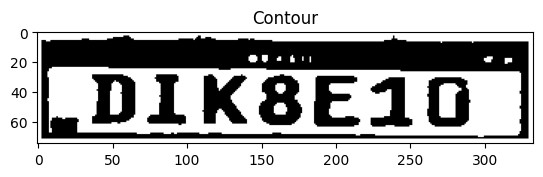

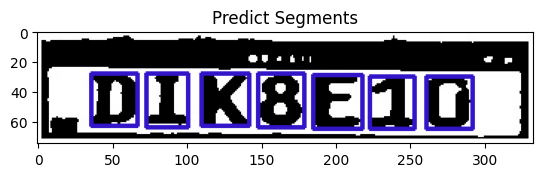

1/1 [==============================] - 0s 42ms/step
DIKBE10


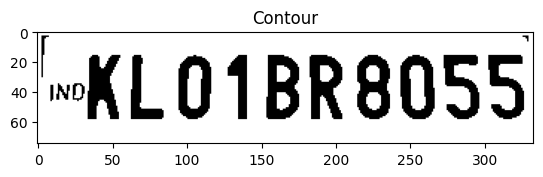

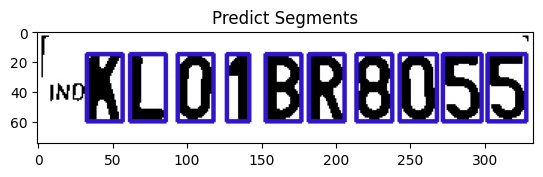

1/1 [==============================] - 0s 40ms/step
KL01BR8055


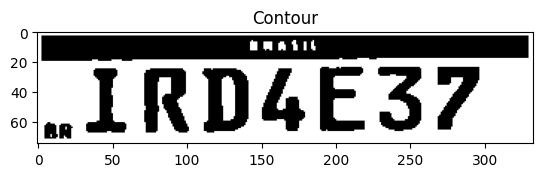

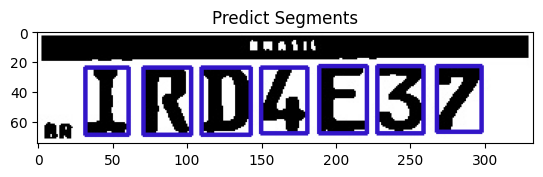

1/1 [==============================] - 0s 40ms/step
IRDWE37


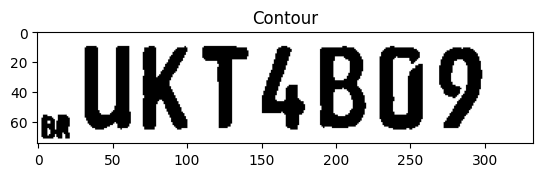

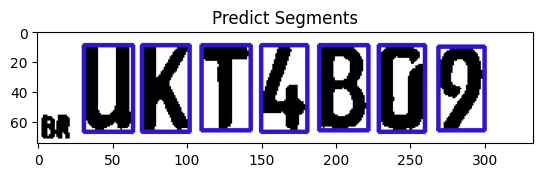

1/1 [==============================] - 0s 40ms/step
UKTWB09


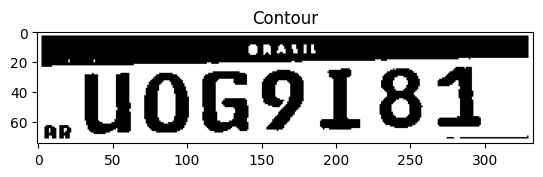

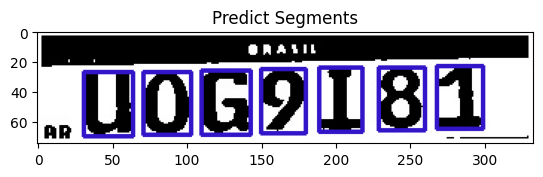

1/1 [==============================] - 0s 40ms/step
U069I81


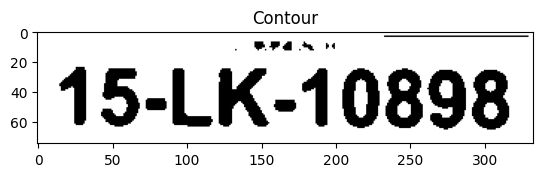

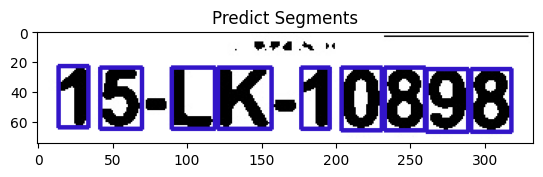

1/1 [==============================] - 0s 39ms/step
15LK1089B


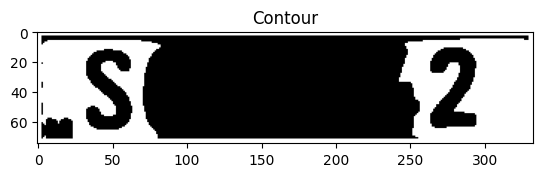

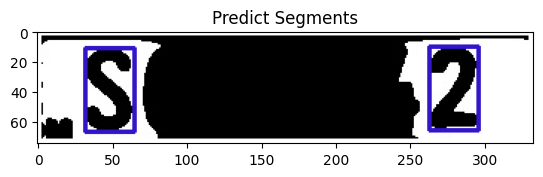

1/1 [==============================] - 0s 40ms/step
S2


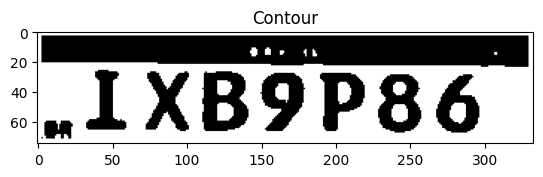

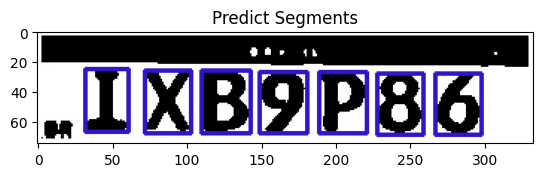

1/1 [==============================] - 0s 30ms/step
IXB9P86


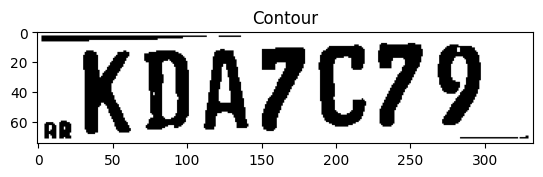

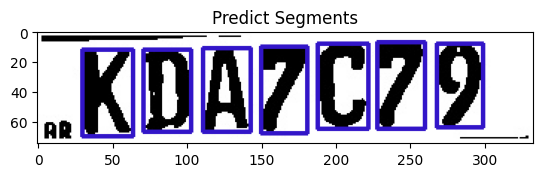

1/1 [==============================] - 0s 40ms/step
KDA7C79


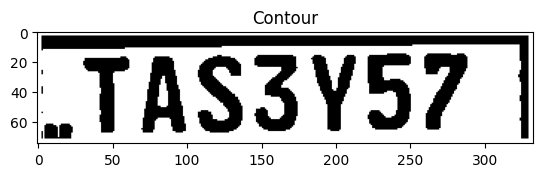

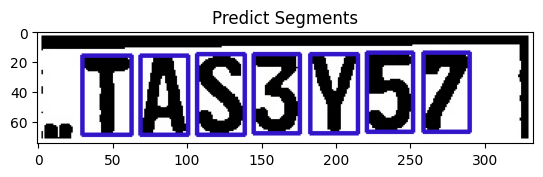

1/1 [==============================] - 0s 50ms/step
TAS3Y57


In [71]:
file_list=os.listdir(r"test_dataset/images")
total_images=len(file_list)
correct_characters=0
for path in file_list:
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    recognized_plate = show_results()
    print(recognized_plate)



In [72]:
model_version=3
model.save(f"../models/{model_version}.h5")